In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import re
import seaborn as sns
import time

from PIL import Image
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud

# Part I: Data Exploration

## Raw data

Data crawled from Giant Bomb API

In [2]:
!wget https://raw.githubusercontent.com/SulmanK/Video-Game-Recommendation-Engine/refs/heads/master/data/fetched_video_games.csv

--2025-07-04 11:49:30--  https://raw.githubusercontent.com/SulmanK/Video-Game-Recommendation-Engine/refs/heads/master/data/fetched_video_games.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12765417 (12M) [text/plain]
Saving to: ‘fetched_video_games.csv’

fetched_video_games 100%[===================>]  12.17M  --.-KB/s    in 0.06s   

2025-07-04 11:49:31 (200 MB/s) - ‘fetched_video_games.csv’ saved [12765417/12765417]



In [5]:
df = pd.read_csv("fetched_video_games.csv", index_col=0)
df.head(5)

id                  name original_game_rating original_release_date_  \
0  82412   100 Hidden Snails 2                  NaN             2021-02-26   
1  67230           100 Seconds                  NaN             2018-03-12   
2  40570  100 Years War Online                  NaN                    NaN   
3  29592         100,000 Games           ESRB: E10+             2009-12-07   
4  66322   100% Hidden Objects                  NaN                    NaN   

  platform                   developer             genre  \
0       PC                         NaN        ['Puzzle']   
1       PC                         NaN  ["Shoot 'Em Up"]   
2       PC                         NaN        ['MMORPG']   
3       PC             Viva Media, LLC   ['Compilation']   
4      Mac  Alawar Entertainment, Inc.        ['Puzzle']   

                  theme                                            concept  \
0                   NaN  ['Steam', '2D', 'Digital Distribution', 'Steam...   
1          ['Abstract']                                          ['Steam']   
2  ['Fantasy', 'Anime']  ['Customization', 'Mount', 'Level Up', 'Online...   
3                   NaN                                 ['Hidden Objects']   
4                   NaN   ['2D', 'Digital Distribution', 'Hidden Objects']   

                franchise                                          image_url  
0  ['100 Hidden Objects']  https://www.giantbomb.com/a/uploads/scale_larg...  
1                     NaN  https://www.giantbomb.com/a/uploads/scale_larg...  
2                     NaN  https://www.giantbomb.com/a/uploads/scale_larg...  
3                     NaN  https://www.giantbomb.com/a/uploads/scale_larg...  
4                     NaN  https://www.giantbomb.com/a/uploads/scale_larg...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37026 entries, 0 to 37025
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      37026 non-null  int64 
 1   name                    37026 non-null  object
 2   original_game_rating    6519 non-null   object
 3   original_release_date_  25370 non-null  object
 4   platform                37026 non-null  object
 5   developer               31400 non-null  object
 6   genre                   34460 non-null  object
 7   theme                   22040 non-null  object
 8   concept                 25765 non-null  object
 9   franchise               10956 non-null  object
 10  image_url               37026 non-null  object
dtypes: int64(1), object(10)
memory usage: 3.4+ MB


In [7]:
df.shape

(37026, 11)

## Preprocessing

Preprocessing including a few steps:

(1) Filter out entries that do not have a genre, theme, and concept value.

(2) Drop entries that contain adult and adult values.

(3) Text Processing 

* Convert the fields from objects into strings.
* All fields with no values were labeled as None.
* Strip the quotation marks.
* Remove whitespace between strings
* Adjust entries with multiple descriptors. 

(4) Creation of our feature inputted into our algorithms, which is the concatenation of the game rating (Age elibility), developer, genre, theme, concept, and franchise. Those features were selected for the following reasons:

- If a game is given a game rating (age rating) do not want to recommend games that are not suitable for the user.

- If a user enjoys a game, they may enjoy a game from the same developer and franchise.

- Genre, theme, and concept features all relate to the atmosphere and environment of the game.

In [8]:
def NONE(x):
    """Function to label a column as None if there are no contents."""
    if x == 'None':
        x = ''
        return x 
    else:
        return x

In [9]:
# Preprocessing

## Drop entries that don't have a genre, theme, and concept value.
df = df.loc[(df['genre'] != 'None') & (df['theme'] != 'None') & (df['concept'] != 'None')].copy()

## Drop entries that are related to anime and adult.
df = df[(~df['theme'].str.contains("Anime", na=False)) & (~df['theme'].str.contains("Adult", na=False))]
df = df.reset_index(drop = True)

## Apply text processing across various columns.
column_list = ['original_game_rating', 'original_release_date_', 'platform',
               'developer', 'genre', 'theme', 'concept', 'franchise']
#for x in df.columns[2:]:
for x in column_list:
    df[x] = df[x].apply(str)
    
    
    ## If a column has no contents, it is labeled as none.
    df[x] = df[x].apply(NONE)
    
    
    ## Remove Brackets
    df[x] = df[x].apply(lambda i: i.strip('[]'))
    
    ## Strip quotation marks
    df[x] = df[x].apply(lambda i: i.strip("''"))
    df[x] = df[x].apply(lambda i: i.strip('""'))
    df[x] = df[x].apply(lambda i: re.sub('"', '', i))
    df[x] = df[x].apply(lambda i: re.sub("'", '', i))
        
    ## Remove Whitespace between multiple string values
    df[x] = df[x].apply(lambda i: i.replace('  ', ' '))  

    # Fix ','
    df[x] = df[x].apply(lambda i: i.replace("','", ' '))

    # Fix ","
    df[x] = df[x].apply(lambda i: i.replace('","', ' '))
    df[x] = df[x].apply(lambda i: i.replace(',', ' '))
    
    # Fix Genre Action Adventure
    
    # Fix '-'
    df[x] = df[x].apply(lambda i: i.replace('-', ' '))
    
    

# Total Content Description
df['total_contents'] = df['original_game_rating'] + " " + df['developer'] + " " + df['genre'] + " " + df['theme'] + " " + df['concept'] + " " + df['franchise'] + " " + df['platform']

In [10]:
df.head()

id                 name original_game_rating original_release_date_  \
0  82412  100 Hidden Snails 2                  nan             2021 02 26   
1  67230          100 Seconds                  nan             2018 03 12   
2  29592        100,000 Games           ESRB: E10+             2009 12 07   
3  66322  100% Hidden Objects                  nan                    nan   
4  37564            1000 Amps                  nan             2012 02 22   

  platform                   developer                         genre  \
0       PC                         nan                        Puzzle   
1       PC                         nan                   Shoot Em Up   
2       PC             Viva Media  LLC                   Compilation   
3      Mac  Alawar Entertainment  Inc.                        Puzzle   
4      Mac              Brandon Brizzi  Platformer  Action Adventure   

               theme                                            concept  \
0                nan  Steam  2D  Digital Distribution  Steam Achieve...   
1           Abstract                                              Steam   
2                nan                                     Hidden Objects   
3                nan           2D  Digital Distribution  Hidden Objects   
4  Fantasy  Abstract  Double Jump  Teleportation  Minimap  WASD Move...   

            franchise                                          image_url  \
0  100 Hidden Objects  https://www.giantbomb.com/a/uploads/scale_larg...   
1                 nan  https://www.giantbomb.com/a/uploads/scale_larg...   
2                 nan  https://www.giantbomb.com/a/uploads/scale_larg...   
3                 nan  https://www.giantbomb.com/a/uploads/scale_larg...   
4                 nan  https://www.giantbomb.com/a/uploads/scale_larg...   

                                      total_contents  
0  nan nan Puzzle nan Steam  2D  Digital Distribu...  
1          nan nan Shoot Em Up Abstract Steam nan PC  
2  ESRB: E10+ Viva Media  LLC Compilation nan Hid...  
3  nan Alawar Entertainment  Inc. Puzzle nan 2D  ...  
4  nan Brandon Brizzi Platformer  Action Adventur...

## Feature exploration

- Our dataframe has 37026 entries now.

- Let's explore the developer, genre, theme, and concept features by examining the distribution using Bar plots.

- **Barplot**

In [11]:
def Bar_Plot(df, x, y, title, x_title, y_title):
    """Function which returns a bar plot of a feature."""    
    # Plot
    bar = px.bar(df, x = x,
                 y = y, orientation = 'h',
                 color = y, color_discrete_sequence = px.colors.qualitative.Pastel
                )
    
    bar.update_xaxes(linewidth = 1, linecolor = 'black', 
                     gridcolor = 'LightPink',  
                     ticks = "outside", tickwidth = 2,
                     tickcolor = 'black', ticklen = 12,
                     title = x_title, title_font = dict(size = 22),
                    ) 
    bar.update_yaxes(linewidth = 1, linecolor = 'black', 
                     gridcolor = 'LightPink', ticks = "outside",
                     tickwidth = 2, tickcolor = 'black',
                     ticklen = 12, title = y_title,
                     title_font = dict(size = 22),
                    )
    
    
    bar.update_layout(
        title = title,
        title_font = dict(size = 26),
        font = dict(size = 14),
        legend = dict(
            x = 1,
            y = 1,
            traceorder = "normal",
            font = dict(
                family = "sans-serif",
                size = 18,
                color = "black"
            ),
            bgcolor = "#f7f7f7",
            bordercolor = "#f7f7f7",
            borderwidth = 1
        ),
        plot_bgcolor = "#f7f7f7", paper_bgcolor = "#f7f7f7",
        width = 1000, height = 600, 
        hoverlabel = dict(
            font_size = 24, 
            font_family = "Rockwell")
    )

    return bar

Majority of games do not have a developer listed.

In [12]:
# Distribution of developers.
Bar_Plot(df = df, x = df['developer'].value_counts().values[0:10],
         y = df['developer'].value_counts().index[0:10], title = 'Distribution of Developers',
         x_title = 'Count', y_title = 'Developer')

Most video games are in the adventure genre.

In [13]:
# Distribution of genres.
Bar_Plot(df = df, x = df['genre'].value_counts().values[0:10],
         y = df['genre'].value_counts().index[0:10], title = 'Distribution of Genres',
         x_title = 'Count', y_title = 'Genre')

Majority of games have a fantasy theme.

In [14]:
# Distribution of themes.
Bar_Plot(df = df, x = df['theme'].value_counts().values[0:10],
         y = df['theme'].value_counts().index[0:10], title = 'Distribution of Themes',
         x_title = 'Count', y_title = 'Theme')

Majority of games have single word titles.

In [15]:
# Distribution of concepts.
Bar_Plot(df = df, x = df['concept'].value_counts().values[0:10],
         y = df['concept'].value_counts().index[0:10], title = 'Distribution of Concepts',
         x_title = 'Count', y_title = 'Concept')

- **Word cloud**

In [14]:
def plot_word_cloud(df):
    """Function to create and plot a worcloud"""

    ## Collect all strings 
    tmp_contents = ''
    for x in df:
        tmp_contents += x
    
    # The regex expression is used to eliminate all non english letters
    regex_expression = r"[a-zA-Z]+"
    
    # Word Cloud
    wc = WordCloud(width = 2500, height = 1000, max_words = 10000,
                      relative_scaling = 0, background_color = 'black', contour_color = "black",
                      regexp = regex_expression, random_state = 2, colormap = 'rainbow',
                      collocations = False,
             ).generate(tmp_contents)
    
    # Set figure size
    plt.figure(figsize = (20, 15))
    
    # Display image
    plt.imshow(wc) 
    
    # No axis details
    plt.axis("off");
    
    return plt.show()

In [15]:
# Wordcloud of total contents.
plot_word_cloud(df = df['total_contents'])

In [16]:
# Wordcloud of genres.
plot_word_cloud(df = df['genre'])

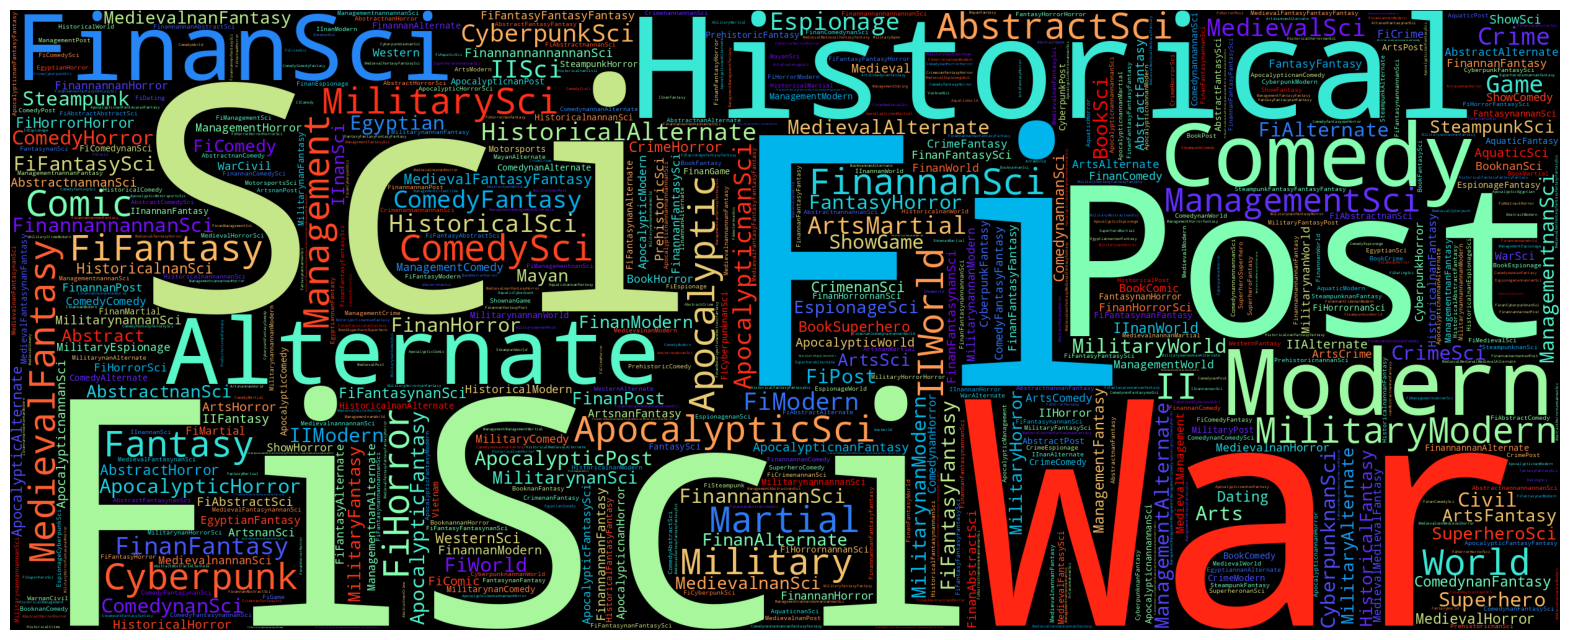

In [17]:
# Wordcloud of themes.
plot_word_cloud(df = df['theme'])

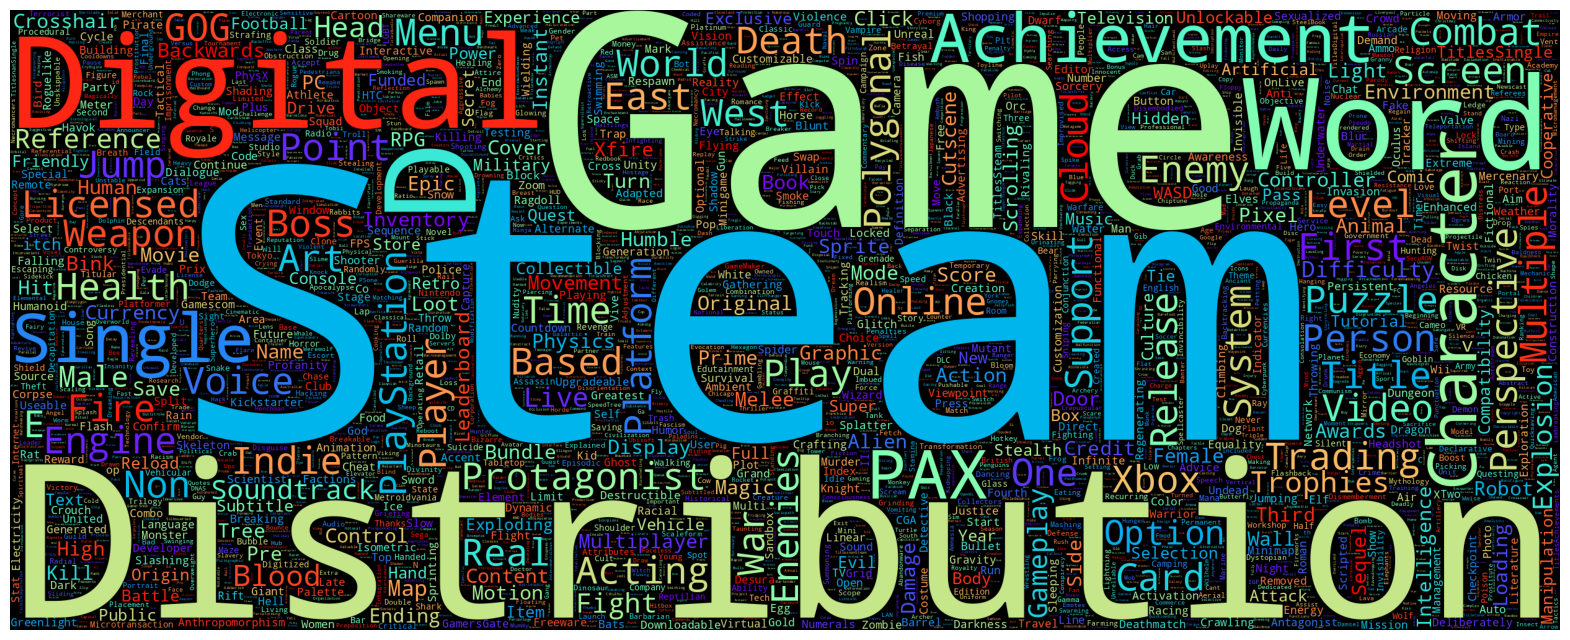

In [18]:
# Wordcloud of concepts.
plot_word_cloud(df = df['concept'])

# Part II: Recommendation Methods

## TF-IDF Vectorization

### Implementation

In [16]:
import math
from collections import Counter

def compute_tf(doc):
    tf_dict = Counter(doc)
    total_terms = len(doc)
    return {term: count/total_terms for term, count in tf_dict.items()}

def compute_idf(docs):
    N = len(docs) 
    idf_dict = {}
    all_terms = set(term for doc in docs for term in doc)
    for term in all_terms:
        df = sum(1 for doc in docs if term in doc)
        idf_dict[term] = math.log((1+N)/((1+df)+1))
    return idf_dict

def tf_idf(tf, idf):
    return {term: tf_val * idf[term] for term, tf_val in tf.items() if term in idf}

def tfidf_func(docs, stopwords=None  ,max_features = 1250):

    if stopwords is None:
        stopwords = set()
    # Tách từ, chuyển thành list và loại bỏ stopword
    tokenized_docs = []
    for doc in docs:
        tokens = doc.lower().split()
        filtered_tokens = [t for t in tokens if t not in stopwords]
        tokenized_docs.append(filtered_tokens)
    
    # Tính tf cho mỗi văn bản
    tf_list = [compute_tf(doc) for doc in tokenized_docs]
    # Tính idf trên toàn tập văn bản
    idf =  compute_idf(tokenized_docs)
    # if-idf
    tfidf_list = [tf_idf(tf, idf) for tf in tf_list]
    # Chuyển thành dataframe
    all_terms = sorted(idf.keys())
    # khởi tạo ma trận ban đầu
    tfidf_matrix = pd.DataFrame([
        [doc.get(term,0.0) for term in all_terms] for doc in tfidf_list],
        columns=all_terms)
    top_terms = tfidf_matrix.sum(axis=0).sort_values(ascending=False).head(max_features).index
    filtered_idf = {term: idf[term] for term in top_terms}
    return tfidf_matrix[top_terms],filtered_idf

In [17]:
#Stop word list
stop_words_list = ['000', '007', '07th', '09',
                       '10', '100', '101', '1047', 
                        '11', '12', '120', '13', '130cm',
                       '13am', '13th', '14', '141', '15',
                       '1500', '16', '17', '18', '180', '1939',
                       '1942', '1960s', '1980s', '1990s',
                       '1995', '1996', '1997', '1998', '1999',
                       '19th', '1c', '1soft', '1st', '20', '2000',
                       '2001','2002', '2003', '2004', '2005', '2006',
                       '2007', '2008', '2009', '2010', '2011', '2012',
                       '2013', '2014', '2015', '2016', '2017', '2018',
                       '2019', '2020', '2020venture',  '20th', '21',
                       '21st', '22', '221b', '227',  '22nd', '23rd', '24',
                       '258', '285',  '2darray',  '2nd', '2x2',
                       '2xl', '3000', '3000ad', '32x', '343',
                       '35', '358', '360', '369', '3a', '3d6',
                       '3ds', '3g', '3lv', '3rd', '3x3', '40',
                       '400', '44', '45', '46', '4a', '4bit', 
                       '4head', '4j', '4sdk', '4x', '50th',
                       '51', '5200', '562', '5656', '59',  '5d', '5pb',
                       '5th', '60', '6010', '64', '6e6e6e', '76', '777',
                       '777next', '7dfps', '7th', '800', '82', '8888888',
                       '88mm', '8floor', '8monkey', '8th', '935', '98',
                       '98demake', '9heads', '9th', 'a2a', 'a2z',
                       '0verflow', '10kbit', '10tacle', '10tons', '2049er', '20xx',
                       '22cans', '2awesome', '2bad', '2d', '2dengine', '2dogs', '2k',
                       '34bigthings', '3d', '3dclouds', '3division', '3do', '3drunkmen',
                       '3rdeye', '3vision', '3vr', '49ers', '49games', '4d', '4fufelz',
                       '4gency', '5bit', 'aaa', 'aaaaaaaaaaaaaaaaaaaaaaaaa', 'ab',
                       'e10', 'e3', 'e404', 'pax',
                       'achievements', 'com', 'comachievements', 'companynameintitle',
                       'crowdfunded', 'declarativetitle', 'digitaldistribution',
                       'e32005', 'e32007', 'e32008', 'e32009', 'e32010',
                       'e32011', 'e32012', 'e32013', 'e32014', 'e32015',
                       'e32016', 'e32017', 'e32018', 'e32019', 'e32020',
                       'easyanticheat', 'epicgamesstore', 'gametitlesthatarealsoquestions', 'gog',
                       'humblebundle', 'kickstarterfunded', 'licensedgame', 'onlive',
                       'paxeast2005', 'paxeast2007', 'paxeast2008', 'paxeast2009',
                       'paxeast2010', 'paxeast2011', 'paxeast2012', 'paxeast2013',
                       'paxeast2014', 'paxeast2015', 'paxeast2016', 'paxeast2017',
                       'paxeast2018', 'paxeast2019', 'paxeast2020',
                       'paxprime', 'paxprime2005', 'paxprime2007', 'paxprime2008',
                       'paxprime2009', 'paxprime2010', 'paxprime2011', 'paxprime2012', 'paxprime2013',
                       'paxprime2014', 'paxprime2015', 'paxprime2016', 'paxprime2017', 'paxprime2018',
                       'paxprime2019', 'paxprime2020', 'paxsouth2005', 'paxsouth2007', 'paxsouth2008',
                       'paxsouth2009', 'paxsouth2010', 'paxsouth2011', 'paxsouth2012', 'paxsouth2013',
                       'paxsouth2014', 'paxsouth2015', 'paxsouth2016', 'paxsouth2017', 'paxsouth2018',
                       'paxsouth2019', 'paxsouth2020',
                       'paxwest2005', 'paxwest2007', 'paxwest2008', 'paxwest2009',
                       'paxwest2010', 'paxwest2011', 'paxwest2012', 'paxwest2013',
                       'paxwest2014', 'paxwest2015', 'paxwest2016', 'paxwest2017',
                       'paxwest2018', 'paxwest2019', 'paxwest2020', 'playstation',
                       'playstationplus', 'playstationtrophies', 'realphotosoncoverart',
                       'secretachievements', 'smartdelivery', 'steam', 'steamapplearcade',
                       'steamcloud', 'steamgreenlight', 'steamremoteplaytogether', 'steamtradingcards',
                       'steamturnnotifications', 'threewordgametitlewithconjunctionorpreposition',
                       'trophies', 'valveindexsupport', 'xboxonexenhanced', 'xboxplayanywhere']

In [ ]:
tmp_df, idf = tfidf_func(df['total_contents'], stopwords=stop_words_list)

In [19]:
dt = {'Words': tmp_df.columns,
        'TF-IDF': [idf[word] for word in tmp_df.columns]}
sorted_df = pd.DataFrame(data=dt).sort_values(by= 'TF-IDF', ascending=False)

In [20]:
## Bar Plot
Bar_Plot(df = sorted_df[0:20], x = 'TF-IDF',
         y = 'Words', title = 'Distribution of TF-IDF Words',
         x_title = 'TF-IDF', y_title = 'Words')

In [24]:
# Word Cloud
## Create word frequencies
tmp_dict = dict(zip(sorted_df['Words'].values, sorted_df['TF-IDF'].values))

## The regex expression is used to eliminate all non english letters
regex_expression = r"[a-zA-Z]+"

## Word Cloud
wc_freq = WordCloud(width = 2500, height = 1000, max_words = 10000,
                  relative_scaling = 0, background_color = 'black', contour_color = "black",
                  regexp = regex_expression, random_state = 2, colormap = 'rainbow',
                  collocations = False,
         ).generate_from_frequencies(tmp_dict)

## Set figure size
plt.figure(figsize = (20, 15))

## Display image
plt.imshow(wc_freq) 

## No axis details
plt.axis("off");

plt.show()

### Cosine similarity

In [25]:
def cosine_sim(v1,v2):
    dot_prod = sum(a*b for a, b in zip(v1,v2))
    norm_v1 = sum(a**2 for a in v1)**0.5
    norm_v2 = sum(b**2 for b in v2)**0.5
    if norm_v1 * norm_v2 ==0:
        return 0.0
    return dot_prod/(norm_v1*norm_v2)

def cosine_sim_row(query_vector, matrix):
   return [cosine_sim(query_vector, matrix.iloc[i]) for i in range(len(matrix))]

In [26]:
def cs_game_recommendations(df, tfidf_matrix, idf_dict ,game_1, game_2, game_3, game_4, game_5):
    import time
    start = time.time()

    # Dùng bản sao để không ảnh hưởng df gốc
    df = df.copy()

    # Lấy danh sách game đầu vào (loại None)
    input_names = [g for g in [game_1, game_2, game_3, game_4, game_5] if g is not None]
    
    # Kiểm tra trùng
    if len(set(input_names)) < len(input_names):
        print("Warning: Duplicate game names in input.")
    
    # Kiểm tra tồn tại trong df
    for g in input_names:
        if g not in df['name'].values:
            return f"Game '{g}' not found in dataset."

    # Lấy index các game input
    input_ids = [df[df['name'] == g].index[0] for g in input_names]

    # Ghép nội dung của các game
    game_text_strings = ''
    for g in input_names:
        content = df[df['name'] == g]['total_contents'].values[0]
        game_text_strings += content + ' '

    # Tiền xử lý văn bản
    tokens = [t for t in game_text_strings.lower().split() if t not in stop_words_list]

    # Tính TF cho văn bản đầu vào
    tf = compute_tf(tokens)
    # Tính TF - IDF cho văn bản đầu vào 
    tfidf_user_dict = tf_idf(tf, idf_dict)

    # Chuyển vector về đúng thứ tự như tfidf_matrix
    tfidf_user_vector = [tfidf_user_dict.get(term, 0.0) for term in tfidf_matrix.columns]

    # Tính cosine similarity giữa `user vector` và tất cả các dòng trong matrix
    sim_scores = cosine_sim_row(tfidf_user_vector, tfidf_matrix)

    # Bỏ game đã nhập
    sim_scores = [(i, s) for i, s in enumerate(sim_scores) if i not in input_ids]

    # Sắp xếp
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Kết quả
    top_indices = [i for i, _ in sim_scores[:16]] #Lấy top 15
    result = df.iloc[top_indices][['name', 'genre']]

    end = time.time()
    print(f'Time Elapsed: {end - start:.2f} seconds')
    return result.reset_index(drop=True)[:10]

### Test cases

In [27]:
# 1 Action Platformer and 1 Action Adventure 
test_case_1 = cs_game_recommendations(df = df,tfidf_matrix = tmp_df, idf_dict = idf, game_1 = '30XX',
                     game_2 = 'Batman: Arkham City', game_3 = None,
                     game_4 = None, game_5 = None)

test_case_1

Time Elapsed: 16.48 seconds


name                                    genre
0             Batman: Arkham Asylum                         Action Adventure
1             Batman: Arkham Knight                         Action Adventure
2            Batman: Arkham Origins                Brawler  Action Adventure
3                           Tyranny                             Role Playing
4                             Crawl           Role Playing  Action Adventure
5  Batman: Arkham Origins Blackgate                         Action Adventure
6                 Horizon Zero Dawn  Role Playing  Shooter  Action Adventure
7    LEGO Batman 2: DC Super Heroes                         Action Adventure
8                          Splasher                       Action  Platformer
9                     Costume Quest                             Role Playing

In [28]:
# 4 Action Platformers and 1 ActionAdventure 
test_case_2 = cs_game_recommendations(df = df,tfidf_matrix = tmp_df, idf_dict = idf, game_1 = '30XX',
                     game_2 = 'Castlevania', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Batman: Arkham Asylum')

test_case_2

Time Elapsed: 16.77 seconds


name  \
0             Batman: Arkham City   
1           Batman: Arkham Knight   
2          Batman: Arkham Origins   
3        Battle Chasers: Nightwar   
4                   Costume Quest   
5  The Elder Scrolls IV: Oblivion   
6                       The Surge   
7        Injustice: Gods Among Us   
8                     Tomb Raider   
9                     Tomb Raider   

                                           genre  
0                               Action Adventure  
1                               Action Adventure  
2                      Brawler  Action Adventure  
3                           Action  Role Playing  
4                                   Role Playing  
5                           Action  Role Playing  
6                           Action  Role Playing  
7                                       Fighting  
8  Shooter  Puzzle  Platformer  Action Adventure  
9          Shooter  Platformer  Action Adventure

In [29]:
# 5 Action Platformers 
test_case_3 = cs_game_recommendations(df = df,tfidf_matrix = tmp_df, idf_dict = idf, game_1 = '30XX',
                     game_2 = 'A.R.E.S. Extinction Agenda EX', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Zack Zero')

test_case_3

Time Elapsed: 16.39 seconds


name                        genre
0                   Hard Room                   Platformer
1                 Berserk Boy           Action  Platformer
2                Orbital Gear  Action  Shooter  Platformer
3  Curse of the Crescent Isle                   Platformer
4                   Solar Gun           Puzzle  Platformer
5                 WarpThrough           Action  Platformer
6                 Ball Kicker           Action  Platformer
7                CreatorCrate           Action  Platformer
8           Featherpunk Prime           Action  Platformer
9            Space Gladiators           Action  Platformer

In [30]:
# 5 MMORGPS
test_case_4 = cs_game_recommendations(df = df,tfidf_matrix = tmp_df, idf_dict = idf, game_1 = 'Albion Online',
                     game_2 = 'ArcheAge', game_3 = 'World of Warcraft',
                     game_4 = 'City of Heroes', game_5 = 'City of Villains')

test_case_4

Time Elapsed: 16.76 seconds


name  \
0                                       Guild Wars   
1           World of Warcraft: The Burning Crusade   
2                            Guild Wars: Nightfall   
3                              Dark Age of Camelot   
4                                     EverQuest II   
5                             Guild Wars: Factions   
6                                   Anarchy Online   
7                                        Helbreath   
8  The Lord of the Rings Online: Shadows of Angmar   
9              Dark Age of Camelot: Shrouded Isles   

                                               genre  
0          Action  Strategy  Adventure  Role Playing  
1                                             MMORPG  
2  Action  Strategy  Adventure  Role Playing  MMORPG  
3                               Role Playing  MMORPG  
4                                             MMORPG  
5  Action  Strategy  Adventure  Role Playing  MMORPG  
6                               Role Playing  MMORPG  
7                                     Action  MMORPG  
8                               Role Playing  MMORPG  
9                               Role Playing  MMORPG

In [31]:
# 4 Action Platformers and 1 ActionAdventure
test_case_5 = cs_game_recommendations(df = df,tfidf_matrix = tmp_df, idf_dict = idf, game_1 = '8-Bit Hordes',
                     game_2 = '8-Bit Invaders!', game_3 = '9th Company: Roots of Terror',
                     game_4 = 'A Game of Thrones: Genesis', game_5 = 'Batman: Arkham Asylum')

test_case_5

Time Elapsed: 16.58 seconds


name                           genre
0              Batman: Arkham City                Action Adventure
1            Batman: Arkham Knight                Action Adventure
2                        DwarfCorp  Simulation  Real Time Strategy
3           Warcraft III: Reforged              Real Time Strategy
4                           C-Dogs                          Action
5           Batman: Arkham Origins       Brawler  Action Adventure
6  The Seven Years War (1756-1763)              Real Time Strategy
7                   Circle Empires              Real Time Strategy
8                     Armored Moon              Real Time Strategy
9                 Battle for Enlor              Real Time Strategy

In [32]:
# 5 Shooters
test_case_6 = cs_game_recommendations(df = df, tfidf_matrix = tmp_df, idf_dict = idf, game_1 = '8bit Killer',
                     game_2 = 'Alien Swarm', game_3 = 'Doom VFR',
                     game_4 = 'Earth Defense Force 5', game_5 = 'Fortnite')

test_case_6

Time Elapsed: 16.67 seconds


name                         genre
0                    Doom          First Person Shooter
1           Duke Nukem 3D          First Person Shooter
2          Gears of War 4                       Shooter
3             Left 4 Dead  Action  First Person Shooter
4       Halo 5: Guardians          First Person Shooter
5                 Gears 5                        Action
6    Halo: Combat Evolved          First Person Shooter
7                  Doom 3          First Person Shooter
8  Doom II: Hell on Earth          First Person Shooter
9         Resident Evil 6      Action  Shooter  Brawler

## K-Nearest Neighbors

### Implementation

In [33]:
tf = TfidfVectorizer(stop_words = stop_words_list, max_features = 1250)
tfidf_matrix = tf.fit_transform(df['total_contents'])

In [34]:
from sklearn.neighbors import KDTree, BallTree

class NearestNeighbors_fromscratch():
    def __init__(self, n_neighbors=5, algorithm='auto', metric='minkowski', p=2, leaf_size=30):
        """
        n_neighbors: number of neighbors to use, ~ K
        algorithm: used to compute the nn
            'kd_tree': use KDTree from sklearn
            'ball_tree': use BallTree from sklearn
            'brute': use a brute-force search
            'auto': attempt to decide the most appropriate algorithm based on the values passed to fit method.
        leaf_size: leaf size passed to BallTree or KDTree.
        metric: use for distance computation (['manhattan', 'euclidean', 'minkowski', 'chebyshev'])
        p: parameter for the Minkowski metric (p=1: manhattan, p=2: euclidean, p=p: minkowsk)
        """
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.metric = metric
        self.p = p
        self.X = None
        self.tree = None
        self._fit_method = None

    def fit(self, X):
        self.X = np.array(X)
        
        method = self.algorithm
        if self.algorithm == 'auto':
            method = self._auto_select_algorithm()

        self._fit_method = method
        if self._fit_method == 'kd_tree':
            self.tree = KDTree(self.X, metric=self.metric, leaf_size=self.leaf_size)
        elif self._fit_method == 'ball_tree':
            self.tree = BallTree(self.X, metric=self.metric, leaf_size=self.leaf_size)
        elif self._fit_method == 'brute':
            pass
        else:
            raise NotImplementedError(f"Algorithm {self._fit_method} is not supported.")

    def _auto_select_algorithm(self):
        """Select matching algorithm for 'auto' mode based on n_features of train dataset."""
        n_samples, n_features = self.X.shape

        if n_features > 50:
            return 'brute'
        elif n_features <= 20:
            return 'kd_tree'
        elif n_features <= 50 and n_samples >= 1000:
            return 'ball_tree'
        else:
            return 'brute'
            
    def kneighbors(self, X_new, return_distance=True):
        """Find K nearest neighbors with each points in X_new"""
        X_new = np.array(X_new)
        
        if self._fit_method == 'kd_tree':
            neigh_dist, neigh_ind = self.tree.query(X_new, k=self.n_neighbors)
        elif self._fit_method == 'ball_tree':
            neigh_dist, neigh_ind = self.tree.query(X_new, k=self.n_neighbors)
        elif self._fit_method == 'brute':
            dists = []
            for new_p in X_new:
                distances = [self._compute_distance(new_p, p_i) for p_i in self.X]
                dists.append(distances)
    
            dists = np.array(dists)
            neigh_ind = np.argsort(dists, axis=1)[:, :self.n_neighbors]
            neigh_dist = np.take_along_axis(dists, neigh_ind, axis=1)
        else:
            raise ValueError("Model not fitted properly.")

        if return_distance:
            return neigh_dist, neigh_ind
        else:
            return neigh_ind

    def _compute_distance(self, x, y):
        """Compute distance between each points in X_new and points in train dataset"""
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x - y) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x - y))
        elif self.metric == 'minkowski':
            return np.sum(np.abs(x - y) ** self.p) ** (1 / self.p)
        elif self.metric == 'chebyshev':
            return np.max(np.abs(x - y))
        else:
            raise NotImplementedError(f"Metric {self.metric} is not supported.")

    def get_params(self):
        """Return model parameters in dictionary."""
        return {
            'n_neighbors': self.n_neighbors,
            'algorithm': self.algorithm,
            'leaf_size': self.leaf_size,
            'metric': self.metric,
            'p': self.p,
            'auto_selected_algorithm': self._fit_method
        }

In [35]:
def knn_game_recommendations(df, tfidf_matrix, tf, game_1, game_2, game_3, game_4, game_5):
    # Recording elapsed time
    start = time.time()
    
    # Dataframe
    df = df

    # Iterate through each game selected and append the game's description into a list  
    game_text_list = []
    for x in game_1, game_2, game_3, game_4, game_5:
        if (x != None) & (df['name'].isin([x]).any() == True):
                          game_text_list.append(((df[df['name'] == x]['total_contents'].values)))
        elif (x != None) & (df['name'].isin([x]).any() == False):
                            return( 'Game inputted is not in dataset')
    
    # Concatenate the strings
    game_text_strings = ''
    for x in game_text_list:
        game_text_strings += x 
    
    # Input IDS
    ## Checks for the datatype of the inputted games either None or the title of the game
    input_ids = []
    for x in game_1, game_2, game_3, game_4, game_5:
        if x != None:
            input_ids.append(df[df['name'] == x].index[0])

    # Nearest Neighbors
    nn = NearestNeighbors_fromscratch(n_neighbors = 15, algorithm='ball_tree', metric = 'minkowski')
    nn.fit(tfidf_matrix.toarray())
    
    # Transforming the predictions
    tf_idf_predictions = tf.transform([str(game_text_strings)])
    results = nn.kneighbors(tf_idf_predictions.todense())
    
    # Recommended Game ID's
    ## Checks to see if any of the recommended titles are not the inputted games - do not get recommended games you selected
    tmp_ids = [x for x in results[1][0]]
    top_10_ids = []
    for x in tmp_ids:
        if x not in input_ids:
            top_10_ids.append(x)
    
    # The TOP 10 games selected
    ## Returns the title of recommendedd games
    top_10_games_list = []
    for x in top_10_ids:
        top_10_games_list.append(df[df.index == x]['name'].values[0])
    
    
    # Labeling the name and genre of the top 10_games
    titles = df[['name', 'genre']]
    indices = pd.Series(df.index, index = df['name'])

    end = time.time()
    print(f'Time Elapsed: {end - start} seconds ')
        
    return titles.iloc[top_10_ids][0:10]

### Test cases


In [36]:
# 1 Action Platformer and 1 Action Adventure 
test_case_1 = knn_game_recommendations(df = df, tfidf_matrix = tfidf_matrix, tf = tf, 
                     game_1 = '30XX', game_2 = 'Batman: Arkham City', 
                     game_3 = None, game_4 = None, game_5 = None)

test_case_1

Time Elapsed: 6.514429569244385 seconds 


name                                    genre
2911            Batman: Arkham Asylum                         Action Adventure
2913            Batman: Arkham Knight                         Action Adventure
2914           Batman: Arkham Origins                Brawler  Action Adventure
30959                         Tyranny                             Role Playing
13466               Horizon Zero Dawn  Role Playing  Shooter  Action Adventure
25862                        Splasher                       Action  Platformer
7038                       Darksiders                 Action  Action Adventure
19596                     Observation                         Action Adventure
6310                            Crawl           Role Playing  Action Adventure
15908  LEGO Batman 2: DC Super Heroes                         Action Adventure

In [37]:
# 4 Action Platformers and 1 ActionAdventure 
test_case_2 = knn_game_recommendations(df = df, tfidf_matrix = tfidf_matrix, tf=tf, 
                     game_1 = '30XX', game_2 = 'Castlevania', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Batman: Arkham Asylum')

test_case_2

Time Elapsed: 6.5939483642578125 seconds 


name                                   genre
2912              Batman: Arkham City                        Action Adventure
2913            Batman: Arkham Knight                        Action Adventure
2914           Batman: Arkham Origins               Brawler  Action Adventure
2942         Battle Chasers: Nightwar                    Action  Role Playing
29458                       The Surge                    Action  Role Playing
6230                    Costume Quest                            Role Playing
25796                    Spider-Man 3                        Action Adventure
7218                    Dead Rising 2          Role Playing  Action Adventure
3502                BioShock Infinite  First Person Shooter  Action Adventure
28301  The Elder Scrolls IV: Oblivion                    Action  Role Playing

In [38]:
# 5 Action Platformers 
test_case_3 = knn_game_recommendations(df = df, tfidf_matrix = tfidf_matrix, tf=tf, 
                     game_1 = '30XX', game_2 = 'A.R.E.S. Extinction Agenda EX', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Zack Zero')

test_case_3

Time Elapsed: 6.514222145080566 seconds 


name                         genre
3303                                 Berserk Boy            Action  Platformer
12741                                  Hard Room                    Platformer
32138                                WarpThrough            Action  Platformer
23100                    Robot Exploration Squad  Platformer  Action Adventure
30968  U.F.O - Unfortunately Fortunate Organisms                        Action
6794                     Cyjin: The Cyborg Ninja                    Platformer
9096                      Echelon: Wind Warriors            Action  Simulation
28742                        The Last Federation                      Strategy
5690                                  Cloudbuilt            Action  Platformer
9092                                     Echelon            Action  Simulation

In [39]:
# 5 MMORGPS
test_case_4 = knn_game_recommendations(df = df, tfidf_matrix = tfidf_matrix, tf=tf, 
                     game_1 = 'Albion Online', game_2 = 'ArcheAge', game_3 = 'World of Warcraft',
                     game_4 = 'City of Heroes', game_5 = 'City of Villains')

test_case_4

Time Elapsed: 6.433028221130371 seconds 


name  \
32882           World of Warcraft: The Burning Crusade   
12453                                       Guild Wars   
6907                               Dark Age of Camelot   
28844  The Lord of the Rings Online: Shadows of Angmar   
12460                            Guild Wars: Nightfall   
12976                                        Helbreath   
9754                                      EverQuest II   
1566                                    Anarchy Online   
12459                             Guild Wars: Factions   
20648                      Perfect World International   

                                                   genre  
32882                                             MMORPG  
12453          Action  Strategy  Adventure  Role Playing  
6907                                Role Playing  MMORPG  
28844                               Role Playing  MMORPG  
12460  Action  Strategy  Adventure  Role Playing  MMORPG  
12976                                     Action  MMORPG  
9754                                              MMORPG  
1566                                Role Playing  MMORPG  
12459  Action  Strategy  Adventure  Role Playing  MMORPG  
20648                                             MMORPG

In [26]:
# 4 Action Platformers and 1 ActionAdventure
test_case_5 = knn_game_recommendations(df = df, tfidf_matrix = tfidf_matrix, tf=tf, 
                     game_1 = '8-Bit Hordes', game_2 = '8-Bit Invaders!', game_3 = '9th Company: Roots of Terror',
                     game_4 = 'A Game of Thrones: Genesis', game_5 = 'Batman: Arkham Asylum')

test_case_5

Time Elapsed: 6.743025779724121 seconds 


name                           genre
2912                Batman: Arkham City                Action Adventure
2913              Batman: Arkham Knight                Action Adventure
8951                          DwarfCorp  Simulation  Real Time Strategy
2914             Batman: Arkham Origins       Brawler  Action Adventure
15289                 Kingdom Elemental    Strategy  Real Time Strategy
2915   Batman: Arkham Origins Blackgate                Action Adventure
32018            Warcraft III: Reforged              Real Time Strategy
6014                  Conan Unconquered              Real Time Strategy
7445                    Defend The Keep              Real Time Strategy
26458                   Stellar Warfare              Real Time Strategy

In [40]:
# 5 Shooters
test_case_6 = knn_game_recommendations(df = df, tfidf_matrix = tfidf_matrix, tf=tf, 
                     game_1 = '8bit Killer', game_2 = 'Alien Swarm', game_3 = 'Doom VFR',
                     game_4 = 'Earth Defense Force 5', game_5 = 'Fortnite')

test_case_6

Time Elapsed: 6.516839265823364 seconds 


name                         genre
16715            Madden NFL 19                      Football
16716            Madden NFL 20                      Football
19195  NFL Quarterback Club 96                      Football
18897                 NBA 2K21            Sports  Basketball
16723            Madden NFL 21                      Football
8314                      Doom          First Person Shooter
11653           Gears of War 4                       Shooter
18896                 NBA 2K20        Simulation  Basketball
15815              Left 4 Dead  Action  First Person Shooter
8797             Duke Nukem 3D          First Person Shooter

## Truncated SVD

### Implementation

In [41]:
class TruncatedSVDFromScratch():
    def __init__(self, n_components):
        self.n_components = n_components
        self.U = None
        self.S = None
        self.V = None
        self.explained_variance_ratio_ = None
        
        
    def fit(self, A):
        # X là ma trận đầu vào
        A = A.astype(float)
        m, n = A.shape
        # Bước 1: Xây dựng ma trận AtA
        At_A = A.T @ A
        
        # Bước 2: Phân tích trị riêng và vector riêng của ma trận ATA
        eigenvalues, eigenvectors = np.linalg.eigh(At_A)
        
        # Bước 3: Sắp xếp eigenvalues theo thứ tự giảm dần
        sorted_idx = np.argsort(-np.abs(eigenvalues)) #np.argsort: lấy chỉ số sắp xếp
        eigenvalues = eigenvalues[sorted_idx]
        eigenvectors = eigenvectors[:, sorted_idx]
        
        # Bước 4: Lấy top k trị riêng lớn nhất
        singular_values = np.sqrt(eigenvalues[:self.n_components])
        V = eigenvectors[:, :self.n_components]
        
        # Bước 5: Tính U_k = AV/lambda
        U = np.zeros((m, self.n_components))
        for i in range(self.n_components):
            if singular_values[i] > 0:
                U[:, i] = (A@V[:, i])/singular_values[i]
            else:
                U[:, i] = A @ V[:, i]

        self.U = U
        self.S = singular_values
        self.V = V
        self.explained_variance_ratio_ = (singular_values ** 2)/ np.sum(singular_values ** 2)
        return self
        
    def transform(self, A):
        # Giảm chiều ma trận X
        if (self.U is None) or (self.S is None) or (self.V is None):
            print("Fit again.")
        else:
            #self.svd_matrix = np.dot(A, self.V_t.T)
            return np.dot(A, self.V)
    
    def fit_transform(self, A):
        return self.fit(A).transform(A)

In [42]:
# Plot to select number of components
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

## TF-IDF
tf = TfidfVectorizer(stop_words=stop_words_list, max_features=1250)
tf_idf_matrix = tf.fit_transform(df['total_contents'].values.astype('U'))

## Calculating cumulative variance based on each component selected
SVD_components_variance = []
Number_of_components = []
for x in range(1, 800, 50):
    tsv = TruncatedSVD(n_components=x, random_state=42).fit(tf_idf_matrix)
    variance = tsv.explained_variance_ratio_.sum()
    Number_of_components.append(x)
    SVD_components_variance.append(variance)

# Find 85%
SVD_components_variance_np = np.array(SVD_components_variance)
threshold_idx = np.argmax(SVD_components_variance_np >= 0.85)
optimal_components = Number_of_components[threshold_idx]
optimal_variance = SVD_components_variance_np[threshold_idx]

## Plot Parameters
plt.figure(figsize=(20, 10))
plt.plot(Number_of_components, SVD_components_variance, '-o')
plt.xlabel('Number of Components', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks([x / 10.0 for x in range(0, 10, 1)], fontsize=18)
plt.ylabel('Variance (%)', fontsize=24)
plt.title('SVD Variance', fontsize=24)

## Annotate plot
plt.text(optimal_components - 50, optimal_variance + 0.015,
         '85% cutoff', size=20, color='red', weight='semibold')

plt.hlines(y=0.85, color='red', linestyle='-', xmin=0.0, xmax=max(Number_of_components))
plt.vlines(x=optimal_components, color='red', linestyle='-', ymin=0.0, ymax=0.85)

plt.text(optimal_components + 5, 0.4,
         f'{optimal_components} components are sufficient', size=20, color='red', weight='semibold')

plt.tight_layout()
plt.show()


In [43]:
#Truncated SVD
tsv = TruncatedSVDFromScratch(n_components=401)
svd_matrix = tsv.fit_transform(tf_idf_matrix.toarray())

# KNN-model
nn_model = NearestNeighbors(n_neighbors=15, algorithm='ball_tree', metric='minkowski')
nn_model.fit(svd_matrix)

NearestNeighbors(algorithm='ball_tree', n_neighbors=15)

In [44]:
def svd_game_recommendations(df, tf, svd, svd_matrix, nn, game_1, game_2, game_3, game_4, game_5, algorithm='cosine'):
    # Recording elapsed time
    start = time.time()
    
    # Dataframe
    df = df

    # Input IDS
    ## Checks for the datatype of the inputted games either None or the title of the game
    input_ids = []
    for x in [game_1, game_2, game_3, game_4, game_5]:
        if x is not None:
            if x in df['name'].values:
                input_ids.append(df[df['name'] == x].index[0])
            else:
                return f"Game '{x}' is not in the dataset."

    # Iterate through each game selected and append the game's description into a list  
    game_text_list = []
    for x in [game_1, game_2, game_3, game_4, game_5]:
        if x is not None and x in df['name'].values:
            game_text_list.append(df[df['name'] == x]['total_contents'].values[0])
    
    # Concatenate the strings
    game_text_strings = ''
    for x in game_text_list:
        game_text_strings += x 

    # Apply TF-IDF and TruncatedSVD to user_input
    user_tf_idf = tf.transform([game_text_strings])
    user_svd = svd.transform(user_tf_idf.toarray())
    
    #Similarity/distance matrix
    if algorithm == 'cosine':
        similarity = cosine_similarity(user_svd, svd_matrix).flatten()
        sim_scores = list(enumerate(similarity))
        sim_scores = [score for score in sim_scores if score[0] not in input_ids]
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        game_indices = [i[0] for i in sim_scores[:10]]
        
    elif algorithm == 'knn':
        # Transforming the predictions
        distances, indices = nn.kneighbors(user_svd)
        game_indices = [i for i in indices[0] if i not in input_ids][:10]
    else:
        return 'invalid algorithm.'
    
    
    end = time.time()
    print(f"Time Elapsed: {end - start:.2f} seconds")
    return df[['name', 'genre']].iloc[game_indices]

### Test cases

- **Cosine similarity**

In [45]:
# 1 Action Platformer and 1 Action Adventure 
test_case_1 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = '30XX', game_2 = 'Batman: Arkham City', game_3 = None,
                     game_4 = None, game_5 = None, algorithm='cosine')

test_case_1

Time Elapsed: 0.15 seconds


name                                    genre
2911    Batman: Arkham Asylum                         Action Adventure
2913    Batman: Arkham Knight                         Action Adventure
2914   Batman: Arkham Origins                Brawler  Action Adventure
13466       Horizon Zero Dawn  Role Playing  Shooter  Action Adventure
30959                 Tyranny                             Role Playing
22585             Remember Me                       Action  Platformer
6230            Costume Quest                             Role Playing
10407                     Fez                       Puzzle  Platformer
6310                    Crawl           Role Playing  Action Adventure
29374        The Sinking City                         Action Adventure

In [46]:
# 4 Action Platformers and 1 ActionAdventure 
test_case_2 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = '30XX', game_2 = 'Castlevania', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Batman: Arkham Asylum', algorithm='cosine')

test_case_2

Time Elapsed: 0.18 seconds


name  \
2912                Batman: Arkham City   
2913              Batman: Arkham Knight   
2914             Batman: Arkham Origins   
2942           Battle Chasers: Nightwar   
6230                      Costume Quest   
30171                       Tomb Raider   
29458                         The Surge   
30170                       Tomb Raider   
22585                       Remember Me   
32193  Watchmen: The End is Nigh Part 2   

                                               genre  
2912                                Action Adventure  
2913                                Action Adventure  
2914                       Brawler  Action Adventure  
2942                            Action  Role Playing  
6230                                    Role Playing  
30171  Shooter  Puzzle  Platformer  Action Adventure  
29458                           Action  Role Playing  
30170          Shooter  Platformer  Action Adventure  
22585                             Action  Platformer  
32193                                Action  Brawler

In [47]:
# 5 Action Platformers 
test_case_3 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model, 
                     game_1 = '30XX', game_2 = 'A.R.E.S. Extinction Agenda EX', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Zack Zero', algorithm='cosine')

test_case_3

Time Elapsed: 0.18 seconds


name                         genre
5690                                  Cloudbuilt            Action  Platformer
23100                    Robot Exploration Squad  Platformer  Action Adventure
12741                                  Hard Room                    Platformer
3303                                 Berserk Boy            Action  Platformer
3737                               Blitz Breaker                    Platformer
6702                  Curse of the Crescent Isle                    Platformer
32138                                WarpThrough            Action  Platformer
19928                               Orbital Gear   Action  Shooter  Platformer
30968  U.F.O - Unfortunately Fortunate Organisms                        Action
6794                     Cyjin: The Cyborg Ninja                    Platformer

In [48]:
# 5 MMORGPS
test_case_4 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = 'Albion Online', game_2 = 'ArcheAge', game_3 = 'World of Warcraft',
                     game_4 = 'City of Heroes', game_5 = 'City of Villains', algorithm='cosine')

test_case_4

Time Elapsed: 0.19 seconds


name  \
32882           World of Warcraft: The Burning Crusade   
6907                               Dark Age of Camelot   
28844  The Lord of the Rings Online: Shadows of Angmar   
20648                      Perfect World International   
12453                                       Guild Wars   
12976                                        Helbreath   
32878                     World of Warcraft: Cataclysm   
1566                                    Anarchy Online   
12460                            Guild Wars: Nightfall   
28840     The Lord of the Rings Online: Mines of Moria   

                                                   genre  
32882                                             MMORPG  
6907                                Role Playing  MMORPG  
28844                               Role Playing  MMORPG  
20648                                             MMORPG  
12453          Action  Strategy  Adventure  Role Playing  
12976                                     Action  MMORPG  
32878                                             MMORPG  
1566                                Role Playing  MMORPG  
12460  Action  Strategy  Adventure  Role Playing  MMORPG  
28840                                             MMORPG

In [49]:
# 4 Action Platformers and 1 ActionAdventure
test_case_5 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = '8-Bit Hordes', game_2 = '8-Bit Invaders!', game_3 = '9th Company: Roots of Terror',
                     game_4 = 'A Game of Thrones: Genesis', game_5 = 'Batman: Arkham Asylum', algorithm='cosine')

test_case_5

Time Elapsed: 0.18 seconds


name                           genre
2912                Batman: Arkham City                Action Adventure
2914             Batman: Arkham Origins       Brawler  Action Adventure
32018            Warcraft III: Reforged              Real Time Strategy
2913              Batman: Arkham Knight                Action Adventure
8951                          DwarfCorp  Simulation  Real Time Strategy
15289                 Kingdom Elemental    Strategy  Real Time Strategy
29667                 The Wolf Among Us                       Adventure
17101  Marvel's Guardians of the Galaxy                Action Adventure
2915   Batman: Arkham Origins Blackgate                Action Adventure
29585                  The Walking Dead                       Adventure

In [50]:
# 5 Shooters
test_case_6 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = '8bit Killer', game_2 = 'Alien Swarm', game_3 = 'Doom VFR',
                     game_4 = 'Earth Defense Force 5', game_5 = 'Fortnite', algorithm='cosine')

test_case_6

Time Elapsed: 0.18 seconds


name                         genre
11653                     Gears of War 4                       Shooter
8797                       Duke Nukem 3D          First Person Shooter
15815                        Left 4 Dead  Action  First Person Shooter
8314                                Doom          First Person Shooter
24205   Serious Sam: The First Encounter  Action  First Person Shooter
16714                      Madden NFL 08  Sports  Simulation  Football
12656               Halo: Combat Evolved          First Person Shooter
12650                  Halo 5: Guardians          First Person Shooter
11650                            Gears 5                        Action
24208  Serious Sam: The Second Encounter               Action  Shooter

- **KNN**

In [51]:
# 1 Action Platformer and 1 Action Adventure 
test_case_1 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = '30XX', game_2 = 'Batman: Arkham City', game_3 = None,
                     game_4 = None, game_5 = None, algorithm='knn')

test_case_1

Time Elapsed: 0.05 seconds


name  \
2911             Batman: Arkham Asylum   
2913             Batman: Arkham Knight   
2914            Batman: Arkham Origins   
2202   Assassin's Creed IV: Black Flag   
10407                              Fez   
22585                      Remember Me   
16130                   Lil Gator Game   
8484                     Dragon Age II   
13466                Horizon Zero Dawn   
16080     Life is Strange: True Colors   

                                                genre  
2911                                 Action Adventure  
2913                                 Action Adventure  
2914                        Brawler  Action Adventure  
2202   Vehicular Combat  Platformer  Action Adventure  
10407                              Puzzle  Platformer  
22585                              Action  Platformer  
16130                                       Adventure  
8484                                     Role Playing  
13466         Role Playing  Shooter  Action Adventure  
16080                                       Adventure

In [52]:
# 4 Action Platformers and 1 ActionAdventure 
test_case_2 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = '30XX', game_2 = 'Castlevania', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Batman: Arkham Asylum', algorithm='knn')

test_case_2

Time Elapsed: 0.07 seconds


name  \
2912                Batman: Arkham City   
2913              Batman: Arkham Knight   
2914             Batman: Arkham Origins   
30171                       Tomb Raider   
2942           Battle Chasers: Nightwar   
6230                      Costume Quest   
22585                       Remember Me   
2202    Assassin's Creed IV: Black Flag   
30170                       Tomb Raider   
32193  Watchmen: The End is Nigh Part 2   

                                                genre  
2912                                 Action Adventure  
2913                                 Action Adventure  
2914                        Brawler  Action Adventure  
30171   Shooter  Puzzle  Platformer  Action Adventure  
2942                             Action  Role Playing  
6230                                     Role Playing  
22585                              Action  Platformer  
2202   Vehicular Combat  Platformer  Action Adventure  
30170           Shooter  Platformer  Action Adventure  
32193                                 Action  Brawler

In [53]:
# 5 Action Platformers 
test_case_3 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = '30XX', game_2 = 'A.R.E.S. Extinction Agenda EX', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Zack Zero', algorithm='knn')

test_case_3

Time Elapsed: 0.07 seconds


name                         genre
23100          Robot Exploration Squad  Platformer  Action Adventure
5690                        Cloudbuilt            Action  Platformer
3737                     Blitz Breaker                    Platformer
14586                        Jailbreak                    Platformer
1982   Aritana and the Harpy's Feather                    Platformer
12741                        Hard Room                    Platformer
19928                     Orbital Gear   Action  Shooter  Platformer
3490                   Bionic Commando            Action  Platformer
5382                 Christmas Mission                    Platformer
3303                       Berserk Boy            Action  Platformer

In [54]:
# 5 MMORGPS
test_case_4 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = 'Albion Online', game_2 = 'ArcheAge', game_3 = 'World of Warcraft',
                     game_4 = 'City of Heroes', game_5 = 'City of Villains', algorithm='knn')

test_case_4

Time Elapsed: 0.07 seconds


name  \
6907                               Dark Age of Camelot   
32882           World of Warcraft: The Burning Crusade   
28844  The Lord of the Rings Online: Shadows of Angmar   
12453                                       Guild Wars   
20648                      Perfect World International   
32878                     World of Warcraft: Cataclysm   
12976                                        Helbreath   
14494                Istaria: Chronicles of the Gifted   
28840     The Lord of the Rings Online: Mines of Moria   
1566                                    Anarchy Online   

                                           genre  
6907                        Role Playing  MMORPG  
32882                                     MMORPG  
28844                       Role Playing  MMORPG  
12453  Action  Strategy  Adventure  Role Playing  
20648                                     MMORPG  
32878                                     MMORPG  
12976                             Action  MMORPG  
14494                               Role Playing  
28840                                     MMORPG  
1566                        Role Playing  MMORPG

In [55]:
# 4 Action Platformers and 1 ActionAdventure
test_case_5 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = '8-Bit Hordes', game_2 = '8-Bit Invaders!', game_3 = '9th Company: Roots of Terror',
                     game_4 = 'A Game of Thrones: Genesis', game_5 = 'Batman: Arkham Asylum', algorithm='knn')

test_case_5

Time Elapsed: 0.07 seconds


name                      genre
2912                     Batman: Arkham City           Action Adventure
2914                  Batman: Arkham Origins  Brawler  Action Adventure
17101       Marvel's Guardians of the Galaxy           Action Adventure
29667                      The Wolf Among Us                  Adventure
2913                   Batman: Arkham Knight           Action Adventure
32018                 Warcraft III: Reforged         Real Time Strategy
29585                       The Walking Dead                  Adventure
28836                            The Longing          Adventure  Puzzle
1529   Amoeba Battle: Microscopic RTS Action         Real Time Strategy
23593                              Sacraboar         Real Time Strategy

In [56]:
# 5 Shooters
test_case_6 = svd_game_recommendations(df = df, tf = tf, svd = tsv, svd_matrix = svd_matrix, nn = nn_model,
                     game_1 = '8bit Killer', game_2 = 'Alien Swarm', game_3 = 'Doom VFR',
                     game_4 = 'Earth Defense Force 5', game_5 = 'Fortnite', algorithm='knn')

test_case_6

Time Elapsed: 0.07 seconds


name                         genre
11653                     Gears of War 4                       Shooter
15815                        Left 4 Dead  Action  First Person Shooter
8797                       Duke Nukem 3D          First Person Shooter
24205   Serious Sam: The First Encounter  Action  First Person Shooter
24208  Serious Sam: The Second Encounter               Action  Shooter
8314                                Doom          First Person Shooter
12650                  Halo 5: Guardians          First Person Shooter
11650                            Gears 5                        Action
7127               Day of Defeat: Source          First Person Shooter
24198                 Serious Sam 3: BFE          First Person Shooter

# Part III: Expanding

In [57]:
games_df = pd.read_csv("fetched_video_games.csv", index_col=0)
games_df.head()

id                  name original_game_rating original_release_date_  \
0  82412   100 Hidden Snails 2                  NaN             2021-02-26   
1  67230           100 Seconds                  NaN             2018-03-12   
2  40570  100 Years War Online                  NaN                    NaN   
3  29592         100,000 Games           ESRB: E10+             2009-12-07   
4  66322   100% Hidden Objects                  NaN                    NaN   

  platform                   developer             genre  \
0       PC                         NaN        ['Puzzle']   
1       PC                         NaN  ["Shoot 'Em Up"]   
2       PC                         NaN        ['MMORPG']   
3       PC             Viva Media, LLC   ['Compilation']   
4      Mac  Alawar Entertainment, Inc.        ['Puzzle']   

                  theme                                            concept  \
0                   NaN  ['Steam', '2D', 'Digital Distribution', 'Steam...   
1          ['Abstract']                                          ['Steam']   
2  ['Fantasy', 'Anime']  ['Customization', 'Mount', 'Level Up', 'Online...   
3                   NaN                                 ['Hidden Objects']   
4                   NaN   ['2D', 'Digital Distribution', 'Hidden Objects']   

                franchise                                          image_url  
0  ['100 Hidden Objects']  https://www.giantbomb.com/a/uploads/scale_larg...  
1                     NaN  https://www.giantbomb.com/a/uploads/scale_larg...  
2                     NaN  https://www.giantbomb.com/a/uploads/scale_larg...  
3                     NaN  https://www.giantbomb.com/a/uploads/scale_larg...  
4                     NaN  https://www.giantbomb.com/a/uploads/scale_larg...

- **Đếm distinct tag của genre**

In [58]:
games_df_copy = games_df.copy()

In [59]:
# Chuyển genre từ str -> list:
import ast
from collections import Counter

# Chuyển genre từ dạng string -> lsit
games_df_copy['genre'] = games_df_copy['genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) 

# Ghép tất cả tag lại
# Ví dụ sau khi ghép xong nó sẽ ra ['Action', 'Horror', 'Horror', 'Adventure']
all_tags = [tag for sublist in games_df_copy['genre'].dropna() for tag in sublist] 

# Đếm distinct tags:
tag_counts = Counter(all_tags)
print(tag_counts)

Counter({'Action': 7514, 'Adventure': 7411, 'Strategy': 5133, 'Simulation': 4349, 'Role-Playing': 4269, 'Puzzle': 3361, 'Platformer': 2738, 'Action-Adventure': 2254, 'Shooter': 1611, 'Sports': 1569, 'Driving/Racing': 1565, 'First-Person Shooter': 1535, 'Educational': 1181, 'Real-Time Strategy': 978, 'MMORPG': 821, "Shoot 'Em Up": 807, 'Fighting': 585, 'Card Game': 575, 'Text Adventure': 567, 'Brawler': 439, 'Vehicular Combat': 354, 'Flight Simulator': 337, 'Trivia/Board Game': 328, 'Music/Rhythm': 302, 'Compilation': 292, 'Minigame Collection': 246, 'Soccer': 242, 'Dual-Joystick Shooter': 235, 'Block-Breaking': 161, 'MOBA': 127, 'Golf': 123, 'Football': 103, 'Baseball': 102, 'Pinball': 91, 'Basketball': 84, 'Gambling': 60, 'Hockey': 54, 'Tennis': 54, 'Fishing': 53, 'Cricket': 49, 'Billiards': 47, 'Wrestling': 46, 'Snowboarding/Skiing': 44, 'Skateboarding': 38, 'Light-Gun Shooter': 32, 'Boxing': 27, 'Bowling': 26, 'Track & Field': 14, 'Fitness': 7, 'Surfing': 6})


- **Đếm distinct tag của theme**

In [60]:
# Chuyển genre từ dạng string -> list
games_df_copy['theme'] = games_df_copy['theme'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ghép tất cả tag lại
all_themes = [tag for sublist in games_df_copy['theme'].dropna() for tag in sublist]

# Đếm distinct tags:
theme_counts = Counter(all_themes)
print(theme_counts)

Counter({'Fantasy': 5777, 'Sci-Fi': 5170, 'Horror': 2203, 'Adult': 2133, 'Comedy': 2118, 'Anime': 2039, 'Management': 1268, 'Abstract': 1132, 'Medieval': 984, 'Crime': 881, 'Post-Apocalyptic': 842, 'Alternate Historical': 835, 'Modern Military': 818, 'World War II': 533, 'Cyberpunk': 497, 'Dating': 403, 'Motorsports': 393, 'Martial Arts': 393, 'Espionage': 297, 'Steampunk': 280, 'Superhero': 224, 'Aquatic': 222, 'Comic Book': 218, 'Western': 192, 'Egyptian': 163, 'Game Show': 145, 'Prehistoric': 125, 'Mayan': 81, 'Civil War': 72, 'Vietnam': 55})


- **Đếm distinct tag của concept**

In [ ]:
# # Chuyển genre từ dạng string -> list
# games_df_copy['concept'] = games_df_copy['concept'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# # Ghép tất cả tag lại
# all_concepts = [tag for sublist in games_df_copy['concept'].dropna() for tag in sublist]

# # Đếm distinct tags:
# concept_counts = Counter(all_concepts)
# print(concept_counts)

## Single filtering

### Implementation

In [73]:
def parse_field(x):
    if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except:
                return []
    elif isinstance(x, list):
        return x
    else:
        return []

In [74]:
# Preprocess data for further usage
games_df_1 = games_df.copy()
# games_df_3['genre'] = games_df_3['genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) 
# games_df_3['theme'] = games_df_3['theme'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) 
# games_df_3['concept'] = games_df_3['concept'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) 

# for col in ['genre', 'theme', 'concept', 'franchise']:
#     games_df_3[col] = games_df_3[col].apply(parse_field)
# games_df_3['developer'] = games_df_3['developer'].fillna('Unknown')

In [75]:
class SingleFiltering():
    # Define class
    def __init__(self, df, game_1, game_2, game_3, game_4, game_5):
        self.df = df
        self.input_names = [game for game in [game_1, game_2, game_3, game_4, game_5] if game is not None]
 
        self.genre_list = None
        self.theme_list = None
        self.concept_list = None
        self.franchise_list = None
        self.developer_list = None
        
        # self.selected_genres = None
        # self.selected_themes = None
        # self.selected_concepts = None
        # self.selected_developers = None
        # self.selected_franchises = None

        for col in ['genre', 'theme', 'concept', 'franchise']:
            self.df[col] = self.df[col].apply(parse_field)
        self.df['developer'] = self.df['developer'].fillna('Unknown')

    # Hàm lọc game theo đặc điểm đầu vào
    def match_and_select(self, field, input_list, num_tags, num_per_tags):
        np.random.shuffle(input_list)
        selected_names = {}
        final_result = []
        for tag in input_list[:num_tags]:
            if field in ['genre', 'theme', 'concept', 'franchise']:
                matched = self.df[self.df[field].apply(lambda x: tag in x)]
            elif field == 'developer':
                matched = self.df[self.df[field].apply(lambda x: isinstance(x, str) and tag in x)].copy()
            n = min(num_per_tags, len(matched))
            matched = matched[~matched['name'].isin(self.input_names)]
            matched = matched[~matched['name'].isin(selected_names)]
            matched = matched.sample(frac=1)
            matched['{}_list'.format(field)] = matched[field]
            selected = matched[['name', '{}_list'.format(field)]].head(n)
            selected_names.update(selected['name'])
            final_result.append(selected.rename(columns={'{}_list'.format(field): field}))
        return pd.concat(final_result, ignore_index = True)
        
    # Áp dụng hàm để cập nhật các danh sách gợi ý theo từng đặc điểm
    def filter(self):
        input_games = self.df[self.df['name'].isin(self.input_names)].copy()
        input_genres = list(set(tag for sublist in input_games['genre'] for tag in sublist)) 
        input_themes = list(set(tag for sublist in input_games['theme'] for tag in sublist))
        input_concepts = list(set(tag for sublist in input_games['concept'] for tag in sublist))
        input_developers = list(set(dev for dev in input_games['developer'] if dev != 'Unknown'))
        input_franchises = list(set(game for gamelist in input_games['franchise'] for game in gamelist))
        
        self.genre_list = self.match_and_select('genre', input_genres, 2, 3)
        self.theme_list = self.match_and_select('theme', input_themes, 2, 3)
        self.concept_list = self.match_and_select('concept', input_concepts, 2, 3)
        self.franchise_list = self.match_and_select('franchise', input_franchises, 2, 3)
        self.developer_list = self.match_and_select('developer', input_developers, 2, 3)

    # In 
    def recommendation(self):
        start = time.time()
        self.filter()
        if not self.genre_list.empty:
            print(f"Game có cùng thể loại:")
            display(self.genre_list)
        if not self.theme_list.empty:
            print(f"Game có cùng chủ đề:")
            display(self.theme_list)
        if not self.concept_list.empty:
            print(f"Game có cùng concept:")
            display(self.concept_list)
        if not self.developer_list.empty:
            print(f"Game có cùng developer:")
            display(self.developer_list)
        if not self.franchise_list.empty:
            print(f"Game chung series:")
            display(self.franchise_list)
        end = time.time()
        print(f"Time elapsed: {end-start:.2f} seconds")

### Test cases

In [77]:
case_1 = SingleFiltering(games_df_1, game_1 = '30XX', game_2 ='Batman: Arkham City', game_3 = None, game_4 = None, game_5 = None)
case_1.recommendation()

Game có cùng thể loại:


name                                  genre
0         Bratz: Babyz                               [Action]
1           Stone Rage                               [Action]
2              Arboria                 [Action, Role-Playing]
3        Treasurenauts         [Platformer, Action-Adventure]
4            Creavures                   [Puzzle, Platformer]
5  Out There Somewhere  [Action, Shooter, Puzzle, Platformer]

Game có cùng chủ đề:


name                       theme
0        Ninja Gaiden: Master Collection     [Fantasy, Martial Arts]
1  Super Bit Adventure: Paragons of Life                   [Fantasy]
2        The Dark Eye: Chains of Satinav                   [Fantasy]
3                      The Great Perhaps  [Sci-Fi, Post-Apocalyptic]
4                                NeonXSZ                    [Sci-Fi]
5                              Vectorman         [Sci-Fi, Cyberpunk]

Game có cùng concept:


name  \
0                            DreamWeb   
1  Die Hard Trilogy 2: Viva Las Vegas   
2                 Beneath a Steel Sky   
3            Snoopy vs. the Red Baron   
4                          Iron Man 2   
5              The Amazing Spider-Man   

                                             concept  
0  [Teleportation, Cutscene, Point and Click, Exp...  
1  [Headshot, Health, Auto-Aim, Heads Up Display,...  
2  [Cutscene, Multiple Endings, Save Point, Point...  
3  [Flight, Anthropomorphism, Alter Ego, Dog, Lic...  
4  [Quick Time Event, Achievements, PlayStation T...  
5  [Open World, Games Based on Movies, Alter Ego,...

Game có cùng developer:


name               developer
0  Batman Arkham Collection  Rocksteady Studios Ltd
1     Batman: Arkham Asylum  Rocksteady Studios Ltd
2         Batman: Arkham VR  Rocksteady Studios Ltd
3                      20XX     Batterystaple Games

Game chung series:


name                 franchise
0                        20XX                    [20XX]
1           Batman: Arkham VR  [Batman, Batman: Arkham]
2    Batman Arkham Collection  [Batman: Arkham, Batman]
3  Batman: Justice Unbalanced     [Batman, DC Universe]

Time elapsed: 0.21 seconds


In [79]:
case_2 = SingleFiltering(games_df_1, game_1 = '30XX', game_2 = 'Castlevania', game_3 = 'Fumiko!', game_4 = '99 Levels To Hell', game_5 = 'Batman: Arkham Asylum')
case_2.recommendation()

Game có cùng thể loại:


name                               genre
0     A Sound Plan                            [Action]
1   Eternal Return  [Action, Real-Time Strategy, MOBA]
2           Bedlam                   [Action, Shooter]
3        StressOut                  [Action-Adventure]
4  Yakuza Kiwami 2         [Brawler, Action-Adventure]
5       Primordian                  [Action-Adventure]

Game có cùng chủ đề:


name                                     theme
0  Nelson Tethers: Puzzle Agent              [Horror, Comedy, Comic Book]
1      Marvel Ultimate Alliance  [Sci-Fi, Superhero, Comic Book, Aquatic]
2                     Domiverse                      [Sci-Fi, Comic Book]
3                   Left 4 Dead                [Horror, Post-Apocalyptic]
4                The Wild Eight                          [Horror, Sci-Fi]
5                     Witchfire                                  [Horror]

Game có cùng concept:


name  \
0  Castlevania: Lords of Shadow - Mirror of Fate   
1             Castlevania Anniversary Collection   
2                                      Alan Wake   
3                   Return to Castle Wolfenstein   
4                                       Homesick   

                                             concept  
0  [Backtracking, Downloadable Content, Henchman,...  
1  [Achievements, Zombie, Vampire, Sprite, Werewo...  
2  [Easter Egg, Save Point, Mind Control, Loading...  
3  [Stealth, Boss Fight, Zombie, Sniping, Headsho...  
4  [Light Bloom, First-Person Perspective, The Lo...

Game có cùng developer:


name            developer
0  Tokimeki Memorial Online               Konami
1                Battlantis               Konami
2                 Mega Zone               Konami
3                      20XX  Batterystaple Games

Game chung series:


name  \
0  Castlevania: Lords of Shadow - Mirror of Fate   
1                 Castlevania: Lords of Shadow 2   
2                 Castlevania Advance Collection   
3                            Batman: Arkham City   
4                              Batman: Vengeance   
5                Batman Forever: The Arcade Game   

                               franchise  
0         [Castlevania, Lords of Shadow]  
1         [Castlevania, Lords of Shadow]  
2                          [Castlevania]  
3  [Batman: Arkham, Batman, DC Universe]  
4                  [Batman, DC Universe]  
5                  [Batman, DC Universe]

Time elapsed: 0.21 seconds


In [81]:
case_3 = SingleFiltering(games_df_1, game_1 = '30XX', game_2 = 'A.R.E.S. Extinction Agenda EX', game_3 = 'Fumiko!', game_4 = '99 Levels To Hell', game_5 = 'Zack Zero')
case_3.recommendation()

Game có cùng thể loại:


name                 genre
0              Bomb the City              [Action]
1             Tropical Storm              [Action]
2                        QIX              [Action]
3                   Gonner 2  [Action, Platformer]
4              Hunter's Soul  [Action, Platformer]
5  Marshmallow in Fruit Land  [Puzzle, Platformer]

Game có cùng chủ đề:


name                        theme
0                        Celeste                    [Fantasy]
1                           Yami                    [Fantasy]
2          Where Are My Friends?  [Fantasy, Sci-Fi, Abstract]
3                        Outwars   [Sci-Fi, Post-Apocalyptic]
4  Baldr Sky Dive1 “Lost Memory”              [Sci-Fi, Adult]
5         Phantasy Star Online 2                     [Sci-Fi]

Game có cùng concept:


name  \
0                           Overland   
1                        Hidden Paws   
2                               Love   
3                          Magicka 2   
4  Wizardry III: Legacy of Llylgamyn   
5                    Resident Evil 6   

                                             concept  
0  [Achievements, Day/Night Cycle, Party System, ...  
1  [Snow, Cats, Hidden Objects, Bundle for Racial...  
2  [Original Soundtrack Release, Checkpoint, Live...  
3  [Steam, Sequel, PlayStation Plus, Humble Bundl...  
4  [Ninja, Experience Points, Magic, Min-maxing, ...  
5  [Quick Time Event, Finishing Move, Cutscene, S...

Game có cùng developer:


name            developer
0  Fimbul          Zaxis Games
1    20XX  Batterystaple Games

Game chung series:


name   franchise
0  A.R.E.S.: Extinction Agenda  [A.R.E.S.]
1                         20XX      [20XX]

Time elapsed: 0.19 seconds


In [82]:
case_4 = SingleFiltering(games_df_1, game_1 = 'Albion Online', game_2 = 'ArcheAge', game_3 = 'World of Warcraft', game_4 = 'City of Heroes', game_5 = 'City of Villains')
case_4.recommendation()

Game có cùng thể loại:


name                              genre
0  The Realm Online  [Adventure, Role-Playing, MMORPG]
1  Hunting on Myths  [Adventure, Role-Playing, MMORPG]
2        Twelve Sky                           [MMORPG]

Game có cùng chủ đề:


name                             theme
0  Mysterious Journey II: Chameleon                 [Fantasy, Sci-Fi]
1  Majesty: The Fantasy Kingdom Sim   [Fantasy, Management, Medieval]
2                 Ghosts 'N Goblins                 [Horror, Fantasy]
3             Young Justice: Legacy           [Superhero, Comic Book]
4                    Mayhem Brawler  [Fantasy, Superhero, Comic Book]
5        The Adventures of Hyperman               [Sci-Fi, Superhero]

Game có cùng concept:


name  \
0                        James Bond 007: Blood Stone   
1                                         Multiwinia   
2                                       PlanetSide 2   
3  Heroes of Might and Magic III: The Shadow of D...   
4                        Heroes of Might and Magic V   
5                          Divinity II: Ego Draconis   

                                             concept  
0  [Quick Time Event, Cutscene, Stealth, Achievem...  
1  [Achievements, Artificial Intelligence, Online...  
2  [Cloak, Sniping, First-Person Perspective, Pla...  
3  [Experience Points, Classical Elements, Hero U...  
4  [Fog of War, Experience Points, Classical Elem...  
5  [Cutscene, Multiple Endings, Achievements, Exp...

Game có cùng developer:


name developer
0  Civilization Online   XLGames
1  ArcheAge: Unchained   XLGames

Game chung series:


name         franchise
0         Warcraft III: Reign of Chaos        [Warcraft]
1  Warcraft II: Beyond the Dark Portal        [Warcraft]
2              Warcraft: Orcs & Humans        [Warcraft]
3          City of Heroes: Going Rogue  [City of Heroes]

Time elapsed: 0.16 seconds


In [83]:
case_5 = SingleFiltering(games_df_1, game_1 = '8-Bit Hordes', game_2 = '8-Bit Invaders!', game_3 = '9th Company: Roots of Terror', game_4 = 'A Game of Thrones: Genesis', game_5 = 'Batman: Arkham Asylum')
case_5.recommendation()

Game có cùng thể loại:


name  \
0                           1503 A.D.: The New World   
1                                  Command & Conquer   
2                                      BCT Commander   
3                           Dungeon Hunter Champions   
4                                   Just Die Already   
5  Kono Subarashii Sekai ni Shukufuku o! Fukkatsu...   

                                            genre  
0                  [Strategy, Real-Time Strategy]  
1                            [Real-Time Strategy]  
2                [Simulation, Real-Time Strategy]  
3  [Action, Role-Playing, Action-Adventure, MOBA]  
4                              [Action-Adventure]  
5                              [Action-Adventure]

Game có cùng chủ đề:


name                theme
0                                        Brain / Out    [Modern Military]
1           Jane's Combat Simulations: Fleet Command    [Modern Military]
2                                     MiG-29 Fulcrum    [Modern Military]
3  Chronicles of a Dark Lord: Episode 1 Tides of ...  [Fantasy, Medieval]
4                                            Xenimus           [Medieval]
5                                         Tap Heroes           [Medieval]

Game có cùng concept:


name  \
0                                Solarix   
1                              Half-Life   
2                         Shadow Warrior   
3  Prince of Persia: The Forgotten Sands   
4                          Sleeping Dogs   
5                  Batman: Arkham Knight   

                                             concept  
0  [Stealth, First-Person Perspective, Crouch, WA...  
1  [Teleportation, Multiple Endings, God Mode, Bo...  
2  [Easter Egg, Teleportation, Cutscene, Achievem...  
3  [Wall Jump, Finishing Move, Achievements, Expe...  
4  [Rubber Band AI, Day/Night Cycle, Persistent W...  
5  [Ninja, Combo, Stealth, Multiple Endings, Achi...

Game có cùng developer:


name               developer
0                   Batman: Arkham Knight  Rocksteady Studios Ltd
1                     Batman: Arkham City  Rocksteady Studios Ltd
2  Suicide Squad: Kill the Justice League  Rocksteady Studios Ltd
3                        Forged Battalion   Petroglyph Games Inc.
4                                 Mytheon   Petroglyph Games Inc.
5                            8-Bit Armies   Petroglyph Games Inc.

Game chung series:


name                                 franchise
0      Batman Arkham Collection                  [Batman: Arkham, Batman]
1           Batman: Arkham City     [Batman: Arkham, Batman, DC Universe]
2        Batman: Arkham Origins     [Batman: Arkham, Batman, DC Universe]
3  LEGO Batman 3: Beyond Gotham  [LEGO, LEGO Batman, Batman, DC Universe]
4                Batman Forever                     [Batman, DC Universe]
5           Batman: Arkham City     [Batman: Arkham, Batman, DC Universe]

Time elapsed: 0.17 seconds


In [85]:
case_6 = SingleFiltering(games_df_1, game_1 = '8bit Killer', game_2 = 'Alien Swarm', game_3 = 'Doom VFR', game_4 = 'Earth Defense Force 5', game_5 = 'Fortnite')
case_6.recommendation()

Game có cùng thể loại:


name                                            genre
0   Maximum Surge                                        [Shooter]
1      Not a Hero                                [Action, Shooter]
2  Synaptic Drive                              [Fighting, Shooter]
3      The Agency  [Action, Shooter, MMORPG, First-Person Shooter]
4    Megatron VGA                [Adventure, First-Person Shooter]
5   Delta Force 2                   [Action, First-Person Shooter]

Game có cùng chủ đề:


name              theme
0              Dark Planet: Battle for Natrolis  [Fantasy, Sci-Fi]
1               The Gardener and the Wild Vines          [Fantasy]
2                                        Midora          [Fantasy]
3                                  Transylvania  [Horror, Fantasy]
4  I'm on Observation Duty 2: Timothy's Revenge           [Horror]
5                            The Outlast Trials           [Horror]

Game có cùng concept:


name  \
0  NBA Jam Tournament Edition   
1                    NBA 2K17   
2                 NBA Live 06   
3                    NBA 2K14   
4     Backyard NBA Basketball   
5                    NBA 2K12   

                                             concept  
0  [Rubber Band AI, Cooperative Play, Cheat Code,...  
1  [Cover Athlete, Microtransaction, Licensed Gam...  
2  [Cover Athlete, Achievements, Instant Replay, ...  
3  [Cover Athlete, Achievements, Voice Chat, Lice...  
4  [Jump, National Basketball Association, Basket...  
5  [Cover Athlete, Achievements, Leaderboard, Dia...

Game có cùng developer:


name          developer
0                 Paragon         Epic Games
1          Age of Wonders         Epic Games
2           Dare to Dream         Epic Games
3                  Dota 2  Valve Corporation
4  Counter-Strike: Source  Valve Corporation
5             Half-Life 2  Valve Corporation

Game chung series:


name      franchise
0                       Doom 64         [Doom]
1                          Doom         [Doom]
2  Doom 3: Resurrection of Evil         [Doom]
3    Alien Swarm: Reactive Drop  [Alien Swarm]

Time elapsed: 0.17 seconds


## Weighted Score

### Implementation

In [86]:
games_df_2 = games_df.copy()

In [87]:
def manual_parse(x):
    if isinstance(x, str):
        # Loại bỏ dấu ngoặc vuông và dấu nháy, sau đó tách bởi dấu phẩy
        x = x.strip("[]")                       # x: "'action', 'adventure'"
        items = [i.strip().strip("'").strip('"') for i in x.split(',')] if x else []
        return items
    else:
        return x

In [88]:
def weighted_score_recommendations(games_df, game_1, game_2, game_3, game_4, game_5):
    """
    Return top games by compute scores by weighted features
    """
    # Recording elapsed time
    start = time.time()
    
    # Dataframe
    df = games_df.copy()

    # Lấy danh sách game đầu vào (loại None)
    input_names = [g for g in [game_1, game_2, game_3, game_4, game_5] if g is not None]
    print(input_names)
    # Kiểm tra tồn tại trong df
    for g in input_names:
        if g not in df['name'].values:
            return f"Game '{g}' not found in dataset."

    # Lấy index các game input
    input_ids = [df[df['name'] == g].index[0] for g in input_names]

    # Xử lý các cột từ chuỗi thành list
    cols = ['genre', 'concept', 'theme']
    for col in cols:
        df[col] = df[col].apply(manual_parse)
        
    # Lấy thông tin 'concept', 'genre', 'theme' của input games (không trùng lặp nên dùng set())
    input_concepts = set()
    input_themes = set()
    input_genres = set()
    for idx in input_ids: 
        input_concepts.update(df.iloc[idx]['concept'])
        input_themes.update(df.iloc[idx]['theme'])
        input_genres.update(df.iloc[idx]['genre'])

    print(f"input genres: {input_genres}")
    print(f"input themes: {input_themes}")
    print(f"input concepts: {input_concepts}")

    # Tính score cho các games khác input trong df, nếu cùng 'concept', 'genre', 'theme' thì score += weight vào
    def compute_game_score(game):
        genre_score = len(input_genres.intersection(game['genre'] if isinstance(game['genre'], list) else [])) * 0.5
        theme_score = len(input_themes.intersection(game['theme'] if isinstance(game['theme'], list) else [])) * 0.3
        concept_score = len(input_concepts.intersection(game['concept'] if isinstance(game['concept'], list) else [])) * 0.2
        return genre_score + theme_score + concept_score

    df['score'] = df.apply(compute_game_score, axis=1)

    # Loại bỏ các input game
    df = df[~df['name'].isin(input_names)]

    # Lọc top_k
    recommendations = df.sort_values(by='score', ascending=False).head(10)
    
    end = time.time()
    print(f'Time Elapsed: {end - start} seconds')

    return recommendations[['name', 'genre', 'theme', 'concept', 'score']]

### Test cases

In [89]:
test_case_1 = weighted_score_recommendations(games_df_2, game_1 = '30XX',
                     game_2 = 'Batman: Arkham City', game_3 = None,
                     game_4 = None, game_5 = None)
test_case_1

['30XX', 'Batman: Arkham City']
input genres: {'Platformer', 'Action-Adventure', 'Action'}
input themes: {'Fantasy', 'Sci-Fi'}
input concepts: {'Poverty', 'Scaleform', 'Freeform Combat', 'Knight', 'Genius-Level Intellect', 'Auto-Save', 'PlayStation Trophies', 'Insanity', 'Male Protagonists', 'Open World', 'Unreal Engine 3', 'Anarchism', 'Retro Skin', 'Sequel', 'PAX East 2020', 'Detective Mode', 'Side Quest', 'Loading Screen Advice', 'PlayStation Plus', 'Humble Bundle', 'PlayStation Now', 'Henchman', 'Xbox 360 Controller Support for PC', 'Profanity', 'Steam', 'Original Soundtrack Release', 'Epic Games Store', 'Downloadable Content', 'Detective', 'PhysX', 'Police', 'British Academy Video Game Awards', 'Big Head Mode', 'Titan', 'Real-Time Combat', 'Alter Ego', 'Origin', 'Supervillain ', "Can't Kill Innocents", 'Comic Book Character', 'Mercenary', 'Joke Ending', 'Cutscene Equipment Mismatch', 'Dodge Jump', 'Origin Access', 'Final Boss'}
Time Elapsed: 0.9644594192504883 seconds


name                                     genre  \
3183    Batman: Arkham Asylum                        [Action-Adventure]   
3186   Batman: Arkham Origins               [Brawler, Action-Adventure]   
3185    Batman: Arkham Knight                        [Action-Adventure]   
18853           Mass Effect 2          [Role-Playing, Action-Adventure]   
2407      Assassin's Creed II            [Platformer, Action-Adventure]   
3811        BioShock Infinite  [First-Person Shooter, Action-Adventure]   
11468        Final Fantasy XV  [Action, Role-Playing, Action-Adventure]   
3810               BioShock 2  [First-Person Shooter, Action-Adventure]   
3809                 BioShock  [First-Person Shooter, Action-Adventure]   
1358   Alice: Madness Returns            [Platformer, Action-Adventure]   

                                                   theme  \
3183                                        [Comic Book]   
3186                      [Crime, Superhero, Comic Book]   
3185                      [Crime, Superhero, Comic Book]   
18853                                           [Sci-Fi]   
2407            [Sci-Fi, Alternate Historical, Medieval]   
3811   [Horror, Sci-Fi, Alternate Historical, Steampunk]   
11468                [Fantasy, Sci-Fi, Post-Apocalyptic]   
3810                                            [Sci-Fi]   
3809           [Sci-Fi, Alternate Historical, Steampunk]   
1358                                   [Horror, Fantasy]   

                                                 concept  score  
3183   [Original Soundtrack Release, PlayStation Trop...    8.1  
3186   [Quick Time Event, Combo, Finishing Move, Stea...    7.3  
3185   [Ninja, Combo, Stealth, Multiple Endings, Achi...    6.7  
18853  [Quick Time Event, Cloak, Cutscene, Multiple E...    5.0  
2407   [Wall Jump, Quick Time Event, Finishing Move, ...    4.9  
3811   [Easter Egg, Teleportation, Finishing Move, St...    4.8  
11468  [Teleportation, Ninja, Cutscene, Stealth, Achi...    4.6  
3810   [Easter Egg, Teleportation, Cutscene, Multiple...    4.4  
3809   [Stealth, Multiple Endings, Achievements, ADAM...    4.2  
1358   [Double Jump, Cutscene, Achievements, Boss Fig...    4.1

In [90]:
# 4 Action Platformers and 1 ActionAdventure 
test_case_2 = weighted_score_recommendations(games_df_2, game_1 = '30XX',
                     game_2 = 'Castlevania', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Batman: Arkham Asylum')

test_case_2

['30XX', 'Castlevania', 'Fumiko!', '99 Levels To Hell', 'Batman: Arkham Asylum']
input genres: {'Platformer', 'Action-Adventure', 'Action'}
input themes: {'Horror', 'Fantasy', 'Sci-Fi', 'Comic Book', 'Abstract'}
input concepts: {'Single Word Titles', 'Moving Platform', 'Assassin', 'Bink Video', 'Destructible Clothing', 'Electrified Water', 'Jump', 'Open World', 'Anarchism', 'Fleaman', 'Sequel', 'Cloak', 'itch.io', 'Boss', '21:9 Ultrawide Support', 'Falling Sequence', 'Original Soundtrack Release', 'Police', 'Digital Distribution', 'Fake Game Over Screen', 'British Academy Video Game Awards', 'Combat-Based Platformer', 'Origin', 'Bundle for Racial Justice and Equality', 'Time Stopping', 'Magic Meter', 'Steam Greenlight', "Can't Kill Innocents", 'Chiptune', 'Villain', 'Adapted into Television', 'Dodge Jump', 'Origin Access', 'Sociopath', 'Melee', 'Belmont Clan', 'Freeform Combat', 'Genius-Level Intellect', 'Bats', 'Game Over', 'PlayChoice-10', 'Skeletons', 'Vent Crawling', 'PlayStation P

name  \
3186           Batman: Arkham Origins   
3811                BioShock Infinite   
11015                       Fallout 3   
3185            Batman: Arkham Knight   
31220  The Elder Scrolls IV: Oblivion   
3184              Batman: Arkham City   
3810                       BioShock 2   
33210                     Tomb Raider   
3809                         BioShock   
30931   The Binding of Isaac: Rebirth   

                                                   genre  \
3186                         [Brawler, Action-Adventure]   
3811            [First-Person Shooter, Action-Adventure]   
11015               [Role-Playing, First-Person Shooter]   
3185                                  [Action-Adventure]   
31220                             [Action, Role-Playing]   
3184                                  [Action-Adventure]   
3810            [First-Person Shooter, Action-Adventure]   
33210            [Shooter, Platformer, Action-Adventure]   
3809            [First-Person Shooter, Action-Adventure]   
30931  [Role-Playing, Dual-Joystick Shooter, Action-A...   

                                                   theme  \
3186                      [Crime, Superhero, Comic Book]   
3811   [Horror, Sci-Fi, Alternate Historical, Steampunk]   
11015   [Sci-Fi, Alternate Historical, Post-Apocalyptic]   
3185                      [Crime, Superhero, Comic Book]   
31220                                [Fantasy, Medieval]   
3184                                           [Fantasy]   
3810                                            [Sci-Fi]   
33210                                                NaN   
3809           [Sci-Fi, Alternate Historical, Steampunk]   
30931                          [Horror, Fantasy, Comedy]   

                                                 concept  score  
3186   [Quick Time Event, Combo, Finishing Move, Stea...   11.4  
3811   [Easter Egg, Teleportation, Finishing Move, St...    9.9  
11015  [Ninja, Stealth, Multiple Endings, Achievement...    9.3  
3185   [Ninja, Combo, Stealth, Multiple Endings, Achi...    8.6  
31220  [Teleportation, Cloak, Cutscene, Stealth, God ...    8.4  
3184   [Unreal Engine 3, Original Soundtrack Release,...    8.4  
3810   [Easter Egg, Teleportation, Cutscene, Multiple...    8.4  
33210  [Quick Time Event, Finishing Move, Cutscene, S...    8.2  
3809   [Stealth, Multiple Endings, Achievements, ADAM...    8.0  
30931  [Easter Egg, Projectile, Teleportation, Multip...    7.9

In [91]:
# 4 Action Platformers and 1 ActionAdventure 
test_case_3 = weighted_score_recommendations(games_df_2, game_1 = '30XX',
                     game_2 = 'A.R.E.S. Extinction Agenda EX', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Zack Zero')

test_case_3

['30XX', 'A.R.E.S. Extinction Agenda EX', 'Fumiko!', '99 Levels To Hell', 'Zack Zero']
input genres: {'Platformer', 'Action'}
input themes: {'Fantasy', 'Sci-Fi', 'Abstract'}
input concepts: {'2.5D', 'Groupees', 'Single Word Titles', 'E3 2013', 'Jump', 'Sequel', 'PAX East 2020', 'GOG.com', 'Dead Boss Platform', 'itch.io', 'Fire Element', 'Steam', 'Double Jump', 'Digital Distribution', 'Collectible', 'Heads Up Display', 'Leaderboard', 'Bundle for Racial Justice and Equality', 'Steam Greenlight', 'Steam Achievements', 'Roguelike', 'Steam Trading Cards', 'Trap', 'Health', 'Roll', 'Boss Fight', 'Final Boss'}
Time Elapsed: 0.8069629669189453 seconds


name  \
25577                                       Rogue Legacy   
12809                      Giana Sisters: Twisted Dreams   
12856                                               Gish   
3995                                         Blasphemous   
3854   BIT.TRIP Presents: Runner2: Future Legend of R...   
26923                                            Shank 2   
28039                               Sonic the Hedgehog 3   
12810  Giana Sisters: Twisted Dreams - Rise of the Ow...   
28029                                  Sonic Generations   
28476                                           Spelunky   

                                        genre                         theme  \
25577      [Action, Role-Playing, Platformer]   [Fantasy, Comedy, Medieval]   
12809                            [Platformer]                     [Fantasy]   
12856                    [Action, Platformer]     [Fantasy, Sci-Fi, Comedy]   
3995   [Action, Platformer, Action-Adventure]   [Horror, Fantasy, Medieval]   
3854       [Action, Music/Rhythm, Platformer]              [Sci-Fi, Comedy]   
26923           [Action, Brawler, Platformer]  [Modern Military, Superhero]   
28039                    [Action, Platformer]             [Fantasy, Sci-Fi]   
12810                    [Puzzle, Platformer]                     [Fantasy]   
28029                    [Action, Platformer]             [Fantasy, Sci-Fi]   
28476  [Puzzle, Platformer, Action-Adventure]               [Sci-Fi, Mayan]   

                                                 concept  score  
25577  [Double Jump, Easter Egg, Projectile, Teleport...    3.9  
12809  [Double Jump, Teleportation, Achievements, Bos...    3.6  
12856  [Multiple Endings, Boss Fight, Physics Manipul...    3.6  
3995   [Cutscene, Multiple Endings, Achievements, Bos...    3.5  
3854   [Cutscene, Achievements, Leaderboard, Loading ...    3.5  
26923  [Combo, Cutscene, Boss Fight, Cooperative Play...    3.4  
28039  [Double Jump, Achievements, Boss Fight, A.I. C...    3.4  
12810  [Double Jump, Wall Jump, Teleportation, Ninja,...    3.4  
28029  [Wall Jump, Achievements, Boss Fight, Time Tra...    3.4  
28476  [Easter Egg, Wall Jump, Teleportation, Ninja, ...    3.2

In [92]:
# 4 Action Platformers and 1 ActionAdventure 
test_case_4 = weighted_score_recommendations(games_df_2, game_1 = 'Albion Online',
                     game_2 = 'ArcheAge', game_3 = 'World of Warcraft',
                     game_4 = 'City of Heroes', game_5 = 'City of Villains')

test_case_4

['Albion Online', 'ArcheAge', 'World of Warcraft', 'City of Heroes', 'City of Villains']
input genres: {'MMORPG'}
input themes: {'Fantasy', 'Crime', 'Superhero'}
input concepts: {'Familiar Horde', 'Assassin', 'Paladins', 'Easter Egg', 'Jump', 'Life Drain', 'Create-A Mode', 'Halloween', 'Platform Exclusive', 'God', 'Skill Tree', 'Never-Ending', 'OpenGL', 'Living Guild', 'Android', 'Nathrezim', 'Level Up Health Refill', 'Warlock', 'Construction', 'Mana', 'Character Creation', 'Cutscene', 'Horse Riding', 'Digital Distribution', 'Multiple Gameplay Perspectives', 'Animal Petting', 'Non-Player Character', 'Rangers', 'Text Bubble', 'Summoning', 'Shield Bash', 'Wolpertinger', 'Warriors', 'Quest Tracking', 'Fridging', 'Widower', 'Robot', 'Breast Slider', 'Pandaren', 'Lawbreaking', 'Hotkey', 'World Video Game Hall of Fame', 'Tauren', 'Orc Protagonist', 'Discontinued MMO', 'Priest', 'Horde', 'Questing', 'Interior Decorating', 'Auction House', 'Undead', 'Melee', 'Worgen', 'Crafting', 'Necromancy',

name     genre      theme  \
36170  World of Warcraft: The Burning Crusade  [MMORPG]  [Fantasy]   
10587                               EverQuest  [MMORPG]  [Fantasy]   
10628          EverQuest: The Planes of Power  [MMORPG]  [Fantasy]   
10620           EverQuest: Secrets of Faydwer  [MMORPG]  [Fantasy]   
10610         EverQuest: Depths of Darkhollow  [MMORPG]  [Fantasy]   
10621         EverQuest: Seeds of Destruction  [MMORPG]  [Fantasy]   
10617               EverQuest: Prophecy of Ro  [MMORPG]  [Fantasy]   
10615     EverQuest: Lost Dungeons of Norrath  [MMORPG]  [Fantasy]   
10629          EverQuest: The Ruins of Kunark  [MMORPG]  [Fantasy]   
10631          EverQuest: The Serpent's Spine  [MMORPG]  [Fantasy]   

                                                 concept  score  
36170  [Easter Egg, Teleportation, Cloak, Combo, Achi...   23.4  
10587  [Teleportation, Cloak, Stealth, Experience Poi...   21.4  
10628  [Teleportation, Cloak, Stealth, Experience Poi...   20.6  
10620  [Teleportation, Cloak, Stealth, Experience Poi...   20.4  
10610  [Teleportation, Cloak, Stealth, Experience Poi...   20.2  
10621  [Teleportation, Cloak, Stealth, Experience Poi...   20.2  
10617  [Teleportation, Cloak, Stealth, Experience Poi...   20.0  
10615  [Teleportation, Cloak, Stealth, Experience Poi...   19.8  
10629  [Teleportation, Cloak, Stealth, Experience Poi...   19.8  
10631  [Teleportation, Cloak, Stealth, Experience Poi...   19.8

In [93]:
# 4 Action Platformers and 1 ActionAdventure 
test_case_5 = weighted_score_recommendations(games_df_2, game_1 = '8-Bit Hordes',
                     game_2 = '8-Bit Invaders!', game_3 = '9th Company: Roots of Terror',
                     game_4 = 'A Game of Thrones: Genesis', game_5 = 'Batman: Arkham Asylum')

test_case_5

['8-Bit Hordes', '8-Bit Invaders!', '9th Company: Roots of Terror', 'A Game of Thrones: Genesis', 'Batman: Arkham Asylum']
input genres: {'Action-Adventure', 'Real-Time Strategy'}
input themes: {'Modern Military', 'Fantasy', 'Medieval', 'Sci-Fi', 'Comic Book'}
input concepts: {'Assassin', 'Bink Video', 'Bards', 'Destructible Clothing', 'Electrified Water', 'Options Menu', 'Open World', 'Anarchism', 'Royalty', 'Integrated Tutorial Sequence', 'Fictional Currencies', '21:9 Ultrawide Support', 'Original Soundtrack Release', 'Police', 'Fake Game Over Screen', 'British Academy Video Game Awards', 'Credits Menu Option', 'Origin', "Can't Kill Innocents", 'Dodge Jump', 'Origin Access', 'Book-like Menus', 'Sociopath', 'Fact-Based Shooter', 'Book Tie-in', 'Freeform Combat', 'Optional Lore', 'Genius-Level Intellect', 'Steam Leaderboards', 'Stealth', 'Vent Crawling', 'PlayStation Plus', 'SpeedTree', 'Humble Bundle', 'PlayStation Now', 'Online', 'Epic Games Store', 'Animal Weaponry', 'Downloadable C

name  \
3186           Batman: Arkham Origins   
3185            Batman: Arkham Knight   
3184              Batman: Arkham City   
3811                BioShock Infinite   
11015                       Fallout 3   
11022              Fallout: New Vegas   
26057                   Saints Row IV   
3810                       BioShock 2   
19489  Middle-earth: Shadow of Mordor   
31220  The Elder Scrolls IV: Oblivion   

                                          genre  \
3186                [Brawler, Action-Adventure]   
3185                         [Action-Adventure]   
3184                         [Action-Adventure]   
3811   [First-Person Shooter, Action-Adventure]   
11015      [Role-Playing, First-Person Shooter]   
11022      [Role-Playing, First-Person Shooter]   
26057               [Shooter, Action-Adventure]   
3810   [First-Person Shooter, Action-Adventure]   
19489                        [Action-Adventure]   
31220                    [Action, Role-Playing]   

                                                   theme  \
3186                      [Crime, Superhero, Comic Book]   
3185                      [Crime, Superhero, Comic Book]   
3184                                           [Fantasy]   
3811   [Horror, Sci-Fi, Alternate Historical, Steampunk]   
11015   [Sci-Fi, Alternate Historical, Post-Apocalyptic]   
11022   [Sci-Fi, Alternate Historical, Post-Apocalyptic]   
26057                 [Sci-Fi, Comedy, Crime, Superhero]   
3810                                            [Sci-Fi]   
19489                                [Fantasy, Medieval]   
31220                                [Fantasy, Medieval]   

                                                 concept  score  
3186   [Quick Time Event, Combo, Finishing Move, Stea...   11.0  
3185   [Ninja, Combo, Stealth, Multiple Endings, Achi...    8.8  
3184   [Unreal Engine 3, Original Soundtrack Release,...    8.4  
3811   [Easter Egg, Teleportation, Finishing Move, St...    7.8  
11015  [Ninja, Stealth, Multiple Endings, Achievement...    7.7  
11022  [Cutscene, Stealth, Multiple Endings, Achievem...    7.3  
26057  [Easter Egg, Wall Jump, Quick Time Event, Comb...    7.2  
3810   [Easter Egg, Teleportation, Cutscene, Multiple...    7.2  
19489  [Teleportation, Combo, Cutscene, Stealth, Achi...    6.9  
31220  [Teleportation, Cloak, Cutscene, Stealth, God ...    6.8

In [94]:
# 4 Action Platformers and 1 ActionAdventure 
test_case_6 = weighted_score_recommendations(games_df_2, game_1 = '8bit Killer',
                     game_2 = 'Alien Swarm', game_3 = 'Doom VFR',
                     game_4 = 'Earth Defense Force 5', game_5 = 'Fortnite')

test_case_6

['8bit Killer', 'Alien Swarm', 'Doom VFR', 'Earth Defense Force 5', 'Fortnite']
input genres: {'First-Person Shooter', 'Shooter'}
input themes: {'Horror', 'Comedy', 'Fantasy', 'Post-Apocalyptic', 'Sci-Fi'}
input concepts: {'2.5D', 'Portland Trail Blazers', 'Detroit Lions', 'Xbox One X Enhanced', 'Bink Video', 'Single Word Titles', 'Novint Falcon Support', 'Secret Area', 'Cleveland Browns', 'Spike Video Game Awards 2011', 'Washington Wizards', 'Female Protagonists', 'Options Menu', 'Steam Remote Play Together', 'Platform Exclusive', 'Sequel', 'Philadelphia 76ers', 'Realistic Magazine Management', 'Boss', 'Muzzle Flash', 'Chicago Bears', 'Tampa Bay Buccaneers', 'Teamplay', 'Construction', 'Sandbox', 'Baltimore Ravens', 'Auto-Aim', 'Body Disintegration', 'Digital Distribution', 'Demon', 'British Academy Video Game Awards', 'Credits Menu Option', 'Source Engine', 'Bullet Time', 'First-Person Perspective', 'Tokyo Game Show 2016', 'Minnesota Timberwolves', 'Miami Heat', 'E3 2017', 'Launch Ti

name  \
9017                                Doom   
9548                       Duke Nukem 3D   
9021                              Doom 3   
30931      The Binding of Isaac: Rebirth   
17345                        Left 4 Dead   
13733  Halo: The Master Chief Collection   
11022                 Fallout: New Vegas   
8334                           Destiny 2   
26722                 Serious Sam 3: BFE   
9025              Doom II: Hell on Earth   

                                                   genre  \
9017                              [First-Person Shooter]   
9548                              [First-Person Shooter]   
9021                              [First-Person Shooter]   
30931  [Role-Playing, Dual-Joystick Shooter, Action-A...   
17345                     [Action, First-Person Shooter]   
13733                [Compilation, First-Person Shooter]   
11022               [Role-Playing, First-Person Shooter]   
8334                [Role-Playing, First-Person Shooter]   
26722                             [First-Person Shooter]   
9025                              [First-Person Shooter]   

                                                  theme  \
9017                                   [Horror, Sci-Fi]   
9548                                   [Sci-Fi, Comedy]   
9021                                   [Horror, Sci-Fi]   
30931                         [Horror, Fantasy, Comedy]   
17345                        [Horror, Post-Apocalyptic]   
13733                                          [Sci-Fi]   
11022  [Sci-Fi, Alternate Historical, Post-Apocalyptic]   
8334                                  [Fantasy, Sci-Fi]   
26722       [Sci-Fi, Comedy, Modern Military, Egyptian]   
9025                 [Horror, Sci-Fi, Post-Apocalyptic]   

                                                 concept  score  
9017   [Double Jump, Easter Egg, Teleportation, Finis...   10.7  
9548   [Easter Egg, Teleportation, God Mode, Achievem...   10.7  
9021   [Easter Egg, Quick Time Event, Teleportation, ...   10.3  
30931  [Easter Egg, Projectile, Teleportation, Multip...   10.1  
17345  [Easter Egg, Achievements, Zombie, Sniping, He...   10.1  
13733  [Easter Egg, Teleportation, Cloak, Rocket Jump...    9.8  
11022  [Cutscene, Stealth, Multiple Endings, Achievem...    9.7  
8334   [Double Jump, Finishing Move, Cutscene, Achiev...    9.7  
26722  [Easter Egg, Projectile, Teleportation, Cutsce...    9.5  
9025   [Easter Egg, Teleportation, Cutscene, Multiple...    9.4

## Combine filtering (with priority)

Lấy thông tin các game đầu vào, lọc tìm các game có các thuộc tính tương tự
- **Filter chính** : genre > theme > concept (các thuộc tính định hình phong cách và gout của người chơi)
- **Filter phụ** dùng khi có quá nhiều kết quả thỏa filter chính: original_release_date
  
Kết quả đề xuất game: có tỷ lệ tương tự với các game input

### Implementation

In [95]:
games_df_3 = games_df.copy()

In [96]:
def recommend_by_filter(df, game_1, game_2, game_3, game_4, game_5, top_k=10):
    start = time.time()

    # Dùng bản sao để không ảnh hưởng df gốc
    df = df.copy()

    # Lấy danh sách game đầu vào (loại None)
    input_names = [g for g in [game_1, game_2, game_3, game_4, game_5] if g is not None]
    
    # Kiểm tra tồn tại trong df
    for g in input_names:
        if g not in df['name'].values:
            return f"Game '{g}' not found in dataset."

    # Lấy index các game input
    input_ids = [df[df['name'] == g].index[0] for g in input_names]

    # Xử lý cột concept (những dòng chưa tách các giá trị concept thành list)
    df['concept'] = df['concept'].apply(lambda x: x if isinstance(x, list) else (x.split("  ") if isinstance(x, str) else []))

    # Lấy thông tin về các game trong input 
    info = {'genre': [], 'theme': [], 'concept':[]}
    for idx in input_ids:
        info['genre'].extend(df.iloc[idx]['genre'] if isinstance(df.iloc[idx]['genre'], list) else [df.iloc[idx]['genre']])
        info['theme'].extend(df.iloc[idx]['theme'] if isinstance(df.iloc[idx]['theme'], list) else [df.iloc[idx]['theme']])
        info['concept'].extend(df.iloc[idx]['concept'] if isinstance(df.iloc[idx]['concept'], list) else [df.iloc[idx]['concept']])

    info_freq = {'genre': {}, 'theme': {}, 'concept': {}}

    # Lọc các giá trị NaN/rỗng
    for key in info:
        info[key] = [x for x in info[key] if pd.notna(x) and str(x).strip() != '']

    # Tính tỷ lệ xuất hiện của các thuộc tính
    for i in info.keys():
        total = len(info[i])
        #if total > 1:
        v = Counter(info[i])
        info_freq[i] = {k: v[k]/total for k in v}
        
    # Chuyển thành set để lọc
    genre_set = set(info['genre'])
    theme_set = set(info['theme'])
    concept_set = set(info['concept'])

    rcm_list = []
    # Lọc theo thể loại
    for genre, ratio_g in info_freq['genre'].items():
        subset_g = df[df['genre'].apply(lambda x: any(genre.lower() in g.lower() for g in x) if isinstance(x, list) else genre.lower() in str(x).lower())]

       #Lọc theo theme
        for theme, ratio_t in info_freq['theme'].items():
            subset_t = subset_g[subset_g['theme'].apply(lambda x: theme in x if isinstance(x, list) else theme ==x)]

            if concept_set:
                subset_temp = subset_t[subset_t['concept'].apply(lambda x: any(c.lower() in [cc.lower() for cc in x] for c in concept_set ))]
                if len(subset_temp) > top_k:
                    subset_c = subset_temp
                else:
                    subset_c = subset_t   #fall_back
            else:
                subset_c = subset_t

            n_final = round(2*top_k*ratio_g*ratio_t)
            result_part = subset_c.sample(n = min(n_final, len(subset_c)))
            rcm_list.append(result_part)
            
    rcm = pd.concat(rcm_list).drop_duplicates(subset = 'id')
    #Shuffle để kết quả đề xuất tăng tính random
    rcm = rcm.sample(frac=1, random_state=42)
    
    # Nếu còn nhiều game sau khi lọc -> Ưu tiên chọn các game ra mắt gần hơn
    if len(rcm) > 2*top_k: 
        rcm['original_release_date_']= pd.to_datetime(rcm['original_release_date_'], errors='coerce')
        rcm = rcm.sort_values(by='original_release_date_', ascending=False).head(top_k)
    else:
        rcm = rcm.head(top_k)
    end = time.time()
    print(f'Time Elapsed: {end - start:.2f} seconds')
    return rcm
   

### Test cases

In [97]:
# 1 Action Platformer and 1 Action Adventure 
test_case_1 =  recommend_by_filter(df = games_df_3, game_1 = '30XX',
                     game_2 = 'Batman: Arkham City', game_3 = None,
                     game_4 = None, game_5 = None)

test_case_1[['name', 'genre']]

Time Elapsed: 0.08 seconds


name                     genre
1932                        Antipole DX  ['Action', 'Platformer']
3959                      Blade & Bones      ['Action-Adventure']
36615                       Yomi Domini      ['Action-Adventure']
1416                        Alien Spidy  ['Action', 'Platformer']
30358                        Tallowmere  ['Action', 'Platformer']
443                    A Hole New World  ['Action', 'Platformer']
22175     Outcast II: The Lost Paradise      ['Action-Adventure']
22205                     Outpost Delta  ['Action', 'Platformer']
33221  Tomb Raider: Unfinished Business      ['Action-Adventure']
26911     Shalnor Legends: Sacred Lands      ['Action-Adventure']

In [103]:
# 4 Action Platformers and 1 ActionAdventure 
test_case_2 = recommend_by_filter(df = games_df_3, game_1 = '30XX',
                     game_2 = 'Castlevania', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Batman: Arkham Asylum')

test_case_2[['name', 'genre']]

Time Elapsed: 0.12 seconds


name                     genre
19565                    Mighty No. 9  ['Action', 'Platformer']
21878                          Oniken  ['Action', 'Platformer']
28562                        Spitkiss  ['Action', 'Platformer']
17978                  Lords of Exile  ['Action', 'Platformer']
15873                  Jack B. Nimble  ['Action', 'Platformer']
17340  Leave Me Alone: A Trip To Hell            ['Platformer']
20283          Mrs. Santa's Gift Hunt      ['Action-Adventure']
18129      Lovecraft's Untold Stories      ['Action-Adventure']
20165                    Mos Speedrun            ['Platformer']
5369                      Castlevania  ['Action', 'Platformer']

In [99]:
# 5 Action Platformers 
test_case_3 = recommend_by_filter(df = games_df_3, game_1 = '30XX',
                     game_2 = 'A.R.E.S. Extinction Agenda EX', game_3 = 'Fumiko!',
                     game_4 = '99 Levels To Hell', game_5 = 'Zack Zero')

test_case_3[['name', 'genre']]

Time Elapsed: 0.09 seconds


name                     genre
1416                           Alien Spidy  ['Action', 'Platformer']
3003                           Ball Kicker  ['Action', 'Platformer']
6901                          CreatorCrate  ['Action', 'Platformer']
3798                       Bionic Commando  ['Action', 'Platformer']
9998                           Electro Man  ['Action', 'Platformer']
24680                      Realms of Chaos  ['Action', 'Platformer']
20165                         Mos Speedrun            ['Platformer']
4089                       Blob From Space            ['Platformer']
25854                    RUN! RUN! LANCER!  ['Action', 'Platformer']
5160   Captain Comic II: Fractured Reality  ['Action', 'Platformer']

In [100]:
# 5 MMORGPS
test_case_4 = recommend_by_filter(df = games_df_3, game_1 = 'Albion Online',
                     game_2 = 'ArcheAge', game_3 = 'World of Warcraft',
                     game_4 = 'City of Heroes', game_5 = 'City of Villains')

test_case_4[['name', 'genre']]

Time Elapsed: 0.08 seconds


name       genre
28112                       Soul of the Ultimate Nation  ['MMORPG']
25081                                 Revelation Online  ['MMORPG']
13487                     Guild Wars Bonus Mission Pack  ['MMORPG']
5984                                     City of Heroes  ['MMORPG']
18872                                    Master of Epic  ['MMORPG']
36164                                 World of Warcraft  ['MMORPG']
36992                                         Zu Online  ['MMORPG']
36867                                            Zodiac  ['MMORPG']
5991                                   City of Villains  ['MMORPG']
11457  Final Fantasy XI Online: Treasures of Aht Urhgan  ['MMORPG']

In [101]:
# 4 Action Platformers and 1 ActionAdventure
test_case_5 = recommend_by_filter(df = games_df_3, game_1 = '8-Bit Hordes',
                     game_2 = '8-Bit Invaders!', game_3 = '9th Company: Roots of Terror',
                     game_4 = 'A Game of Thrones: Genesis', game_5 = 'Batman: Arkham Asylum')

test_case_5[['name', 'genre']]

Time Elapsed: 0.10 seconds


name                   genre
3602                Besieger  ['Real-Time Strategy']
18870      Master of Defense  ['Real-Time Strategy']
17132            Lambda Wars  ['Real-Time Strategy']
15246                Illagus    ['Action-Adventure']
560           A Year Of Rain  ['Real-Time Strategy']
9502               Dry Grass    ['Action-Adventure']
2236           Armor Clash 3  ['Real-Time Strategy']
24723              Recompile    ['Action-Adventure']
337             8-Bit Hordes  ['Real-Time Strategy']
17966  Lord Monarch Original  ['Real-Time Strategy']

In [102]:
# 5 Shooters
test_case_6 = recommend_by_filter(df = games_df_3, game_1 = '8bit Killer',
                     game_2 = 'Alien Swarm', game_3 = 'Doom VFR',
                     game_4 = 'Earth Defense Force 5', game_5 = 'Fortnite')

test_case_6[['name', 'genre']]

Time Elapsed: 0.31 seconds


name                                genre
347         8bit Killer  ['Shooter', 'First-Person Shooter']
1453   All Contact Lost  ['Shooter', 'First-Person Shooter']
23975           Pulstar                          ['Shooter']
12631      Gears of War                          ['Shooter']
12632    Gears of War 4                          ['Shooter']
32424   The Stranger VR                          ['Shooter']
19709           Minimum                          ['Shooter']
28755   Star Defender 4                          ['Shooter']
30503      Tech Madness                          ['Shooter']
11939          Fortnite                          ['Shooter']